### Nonlinear interaction of energetic electrons with large amplitude chorus
Bortnik, Thorne and Inan 2008


In [1]:
import numpy as np
import os
import sys
import inspect
import matplotlib.pyplot as plt


#Define WPIT package location
current_dir =  os.path.abspath(os.path.dirname('__file__'))
fpath = os.path.abspath(current_dir + "/..")
sys.path.append(fpath)


import WPIT.Environment_mod as env
import WPIT.WaveProperties_mod as wave
import WPIT.WPI_mod.whistler_electron_mod as wpi



### 1. Define simulation parameters

Here we define all the initial parameters of the simulation in respect with the particle and the wave

In [2]:
ne_0=10**7 #equatorial electron density in m^-3
L_shell=5  #L-shell of the simulation 
By_wave=35*10**(-12)   # By component of the wave in Tesla
aeq0_deg=68   #initial equatorial pitch angle in deg
aeq0=np.deg2rad(aeq0_deg) #convert pitch angle to rad
Ekev0=168.3 #initial energy in keV
lamda0_deg=-9  # starting electron latitude in deg
lamda0=np.deg2rad(lamda0_deg) #convert latitude to rad
theta0_deg=0.0001# initial wave normal angle in deg
theta0=np.deg2rad(theta0_deg) #convert wave normal angle to rad
f_wave=2000 # wave frequency in Hz
w_wave=2*np.pi*f_wave #wave angular frequency in rad/s
m_res=1 #WPI resonance number (0=Landau resonance)
eta0_deg=np.linspace(0,361,12) #initial electron-wave phases in deg
eta0=np.deg2rad(eta0_deg) #convert initial electron-wave phases to rad

t=0.1 #simulation duration (s)
h=0.00001  #simulation stepsize
Nsteps=int(t/h) #number of simulation steps
print(eta0)

[0.         0.57278533 1.14557065 1.71835598 2.29114131 2.86392664
 3.43671196 4.00949729 4.58228262 5.15506795 5.72785327 6.3006386 ]


### 2. Find initial electron's local pitch angle 

In [3]:

alpha0=env.aeq2alpha(L_shell,lamda0,aeq0)

print('\u03B1:',np.rad2deg(alpha0))
# print('\N{GREEK SMALL LETTER alpha}')

α: 78.37445795337882


### 3. Find initial momentum, velocity and lorentz factor

In [4]:
upar0,uper0,ppar0,pper0,gamma0=env.initial_velocity(Ekev0,alpha0,env.const.me)

print('upar0:',upar0,'m/s')
print('uper0:',uper0,'m/s')
print('ppar0:',ppar0,'Ns')
print('pper0:',pper0,'Ns')
print('gamma0:',gamma0)

upar0: 39805013.39163095 m/s
uper0: 193476979.55557317 m/s
ppar0: 4.820203623516892e-23 Ns
pper0: 2.3429170309410255e-22 Ns
gamma0: 1.3293478962221865


### 5. Calculate all the initial parameters

In [5]:

Bmag0=env.Bmag_dipole(L_shell,lamda0)
ne0=env.density_FL_denton(ne_0,lamda0)

#assuming 94%H+, 5.4%He+, 0.6%O+
nH0=0.77*ne0
nHe0=0.2*ne0
nO0=0.03*ne0    

S0,D0,P0,R0,L0=wave.stix_parameters(w_wave, ne0, nH0, nHe0, nO0, Bmag0)

eta_sq_plus0,eta_sq_minus0,mu0,kappa0,kappaz0,kappax0=wave.refr_index_full(theta0,w_wave,S0,P0,R0,L0)

wce0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.me)


Bxw0, Byw0, Bzw0, Exw0, Eyw0, Ezw0=wave.wave_amplitudes_bell(mu0,P0,D0,S0,By_wave,theta0)
dwceds0=env.dwc_ds(wce0,lamda0,L_shell)

gamma0,w10,w20,wtau_sq0,R10,R20,beta0=wpi.wpi_params(m_res,ppar0,pper0,Bxw0, Byw0,Exw0,Eyw0,Ezw0,kappaz0,kappax0,wce0)
v_para_res0, v_per_res0, v_tot_res0, E_res0,gamma_res0=wave.resonant_velocity(m_res,w_wave,kappaz0,wce0,alpha0,env.const.me)

wcH0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mH)
wcHe0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mHe)
wcO0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mO)

wpe0=env.omega_plasma(ne0,env.const.qe,env.const.me)
wpH0=env.omega_plasma(nH0,env.const.qi,env.const.mH)
wpHe0=env.omega_plasma(nHe0,env.const.qi,env.const.mHe)
wpO0=env.omega_plasma(nO0,env.const.qi,env.const.mO)
wuhr0=env.omega_uhr(wce0,wpe0)
wlhr0=env.omega_lhr(wce0, wpe0, wcH0, wpH0)

dwcHds0=env.dwc_ds(wcH0,lamda0,L_shell)
dwcHeds0=env.dwc_ds(wcHe0,lamda0,L_shell)
dwcOds0=env.dwc_ds(wcO0,lamda0,L_shell)



### 4. Allocate outputs


In [6]:
pper=np.zeros((len(eta0),Nsteps+1))
ppar=np.zeros((len(eta0),Nsteps+1))
eta=np.zeros((len(eta0),Nsteps+1))
lamda=np.zeros((len(eta0),Nsteps+1))
time=np.zeros((len(eta0),Nsteps+1))
uper=np.zeros((len(eta0),Nsteps+1))
upar=np.zeros((len(eta0),Nsteps+1))
zeta=np.zeros((len(eta0),Nsteps+1))
alpha=np.zeros((len(eta0),Nsteps+1))
alpha2=np.zeros((len(eta0),Nsteps+1))
aeq=np.zeros((len(eta0),Nsteps+1))
aeq2=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Bw_out=np.zeros((len(eta0),Nsteps+1))
Ew_out=np.zeros((len(eta0),Nsteps+1))
vresz_o=np.zeros((len(eta0),Nsteps+1))
Eres_o=np.zeros((len(eta0),Nsteps+1))

mu_out=np.zeros((len(eta0),Nsteps+1))
deta_dt=np.zeros((len(eta0),Nsteps+1))
S_stix=np.zeros((len(eta0),Nsteps+1))
D_stix=np.zeros((len(eta0),Nsteps+1))
P_stix=np.zeros((len(eta0),Nsteps+1))
R_stix=np.zeros((len(eta0),Nsteps+1))
L_stix=np.zeros((len(eta0),Nsteps+1))
kx_out=np.zeros((len(eta0),Nsteps+1))
kz_out=np.zeros((len(eta0),Nsteps+1))
wh_out=np.zeros((len(eta0),Nsteps+1))
dwh_dt_out=np.zeros((len(eta0),Nsteps+1))
gamma_out=np.zeros((len(eta0),Nsteps+1))
Phi_out=np.zeros((len(eta0),Nsteps+1))
E_kin=np.zeros((len(eta0),Nsteps+1))
v_res_out=np.zeros((len(eta0),Nsteps+1))
E_res_out=np.zeros((len(eta0),Nsteps+1))

Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
S_out=np.zeros((len(eta0),Nsteps+1))
wtrsq_out=np.zeros((len(eta0),Nsteps+1))
C0_out=np.zeros((len(eta0),Nsteps+1))
C1p_out=np.zeros((len(eta0),Nsteps+1))
C1m_out=np.zeros((len(eta0),Nsteps+1))
kappa_out=np.zeros((len(eta0),Nsteps+1))

ne_out=np.zeros((len(eta0),Nsteps+1))
nH_out=np.zeros((len(eta0),Nsteps+1))
nHe_out=np.zeros((len(eta0),Nsteps+1))
nO_out=np.zeros((len(eta0),Nsteps+1))

wce_out=np.zeros((len(eta0),Nsteps+1))
wcH_out=np.zeros((len(eta0),Nsteps+1))
wcHe_out=np.zeros((len(eta0),Nsteps+1))
wcO_out=np.zeros((len(eta0),Nsteps+1))
wpe_out=np.zeros((len(eta0),Nsteps+1))
wpHe_out=np.zeros((len(eta0),Nsteps+1))
wpH_out=np.zeros((len(eta0),Nsteps+1))
wpO_out=np.zeros((len(eta0),Nsteps+1))
wlhr_out=np.zeros((len(eta0),Nsteps+1))
wuhr_out=np.zeros((len(eta0),Nsteps+1))
dwceds_out=np.zeros((len(eta0),Nsteps+1))
dwcHds_out=np.zeros((len(eta0),Nsteps+1))
dwcHeds_out=np.zeros((len(eta0),Nsteps+1))
dwcOds_out=np.zeros((len(eta0),Nsteps+1))

Bmag_out=np.zeros((len(eta0),Nsteps+1))

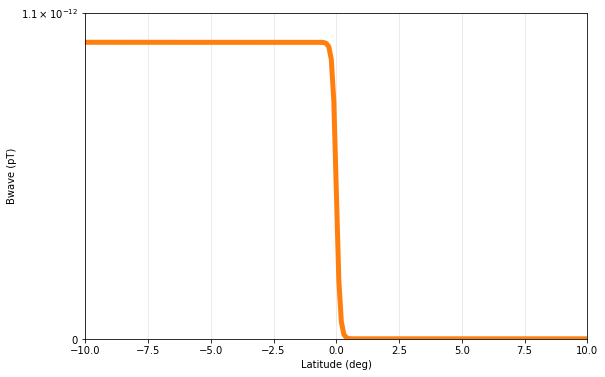

In [7]:

lamda_packet2=np.arange(-10,10,0.1)
lamda_packet_rad2=np.deg2rad(lamda_packet2)

Byw0_packet2=1*10**(-12)
shape=7
direction='south'
location=0
Bw_packet2=[]

for i in range(0,len(lamda_packet2)):

    Bytmp=wave.wave_packet_one_sided(Byw0_packet2,lamda_packet_rad2[i],shape,location,direction)

#     print(Bytmp)
    Bw_packet2.append(Bytmp)

    
fig, ax = plt.subplots(figsize=(9,6))
s=5
ax.plot(lamda_packet2,Bw_packet2,c='tab:orange',linewidth=s)
ax.grid(alpha=.3)
ax.set_xlim(-10,10)
ax.set_yscale('symlog')
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Bwave (pT)')

ax.set_ylim(0,1.1*10**(-12))
# ticks=np.arange(0,2*np.pi,1)
# cbar=fig.colorbar(cmap, ticks=ticks)
# cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)
#     ax.axvline(x=-5,color="black", linestyle="--")
plt.show()


/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/tourgaidis/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


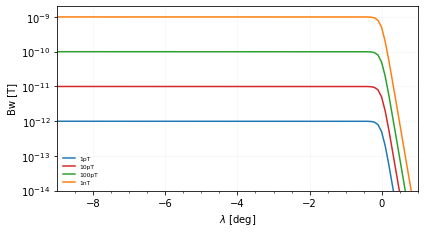

In [8]:
import matplotlib.ticker as tck
lamda_packet2=np.arange(-10,10,0.1)
lamda_packet_rad2=np.deg2rad(lamda_packet2)
inch_to_mm=0.0393700787
Byw1pT=1*10**(-12)
Byw10pT=10*10**(-12)
Byw100pT=100*10**(-12)
Byw1nT=1000*10**(-12)
shape=7
direction='south'
location=0
Bw_1pT=[]
Bw_10pT=[]
Bw_100pT=[]
Bw_1nT=[]

for i in range(0,len(lamda_packet2)):

    Bytmp1pT=wave.wave_packet_one_sided(Byw1pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp10pT=wave.wave_packet_one_sided(Byw10pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp100pT=wave.wave_packet_one_sided(Byw100pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp1nT=wave.wave_packet_one_sided(Byw1nT,lamda_packet_rad2[i],shape,location,direction)

    Bw_1pT.append(Bytmp1pT)
    Bw_10pT.append(Bytmp10pT)
    Bw_100pT.append(Bytmp100pT)
    Bw_1nT.append(Bytmp1nT)



###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=0.1

# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
ax.plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
ax.plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
ax.plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')
ax.grid(alpha=.1)
ax.set_xlim(-9,1)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'Bw [T]')

ax.set_yscale('log')
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(10**(-14),2*10**(-9))
ax.legend(frameon=False,loc=0, prop={'size': 6})
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('wave_fields_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



### Runge-Kutta

In [9]:
for k in range(0,len(eta0)):
    i=0
    time[k,0]=0
    pper[k,0]=pper0
    ppar[k,0]=ppar0
    eta[k,0]=eta0[k]
    lamda[k,0]=lamda0
    zeta[k,0]=0
    upar[k,0]=upar0
    uper[k,0]=uper0
    alpha[k,0]=alpha0
    alpha2[k,0]=alpha0
    aeq[k,0]=aeq0
    aeq2[k,0]=aeq0
    mu_out[k,0]=mu0
    deta_dt[k,0]=0
    S_stix[k,0]=S0
    D_stix[k,0]=D0
    P_stix[k,0]=P0
    R_stix[k,0]=R0
    L_stix[k,0]=L0
    kappa_out[k,0]=kappa0
    kx_out[k,0]=kappax0
    kz_out[k,0]=kappaz0
    dwh_dt_out[k,0]=dwceds0
    gamma_out[k,0]=gamma0
    E_kin[k,0]=1.602176487E-16*Ekev0 #from keV to ergs
    v_res_out[k,0]=v_para_res0
    E_res_out[k,0]=E_res0
    Bxw_out[k,0]=Bxw0
    Byw_out[k,0]=Byw0
    Bzw_out[k,0]=Bzw0
    Exw_out[k,0]=Exw0
    Eyw_out[k,0]=Eyw0
    Ezw_out[k,0]=Ezw0
    wce_out[k,0]=wce0
    wcH_out[k,0]=wcH0
    wcHe_out[k,0]=wcHe0
    wcO_out[k,0]=wcO0
    wpe_out[k,0]=wpe0
    wpHe_out[k,0]=wpHe0
    wpH_out[k,0]=wpH0
    wpO_out[k,0]=wpO0
    wlhr_out[k,0]=wlhr0
    wuhr_out[k,0]=wuhr0

    ne_out[k,0]=ne0
    nH_out[k,0]=nH0
    nHe_out[k,0]=nHe0
    nO_out[k,0]=nO0
    dwceds_out[k,0]=dwceds0
    dwcHds_out[k,0]=dwcHds0
    dwcHeds_out[k,0]=dwcHeds0
    dwcOds_out[k,0]=dwcOds0
    Bmag_out[k,0]=Bmag0
#     print(np.rad2deg(eta[k,0]))
    while i<Nsteps:
    ######################################################################################################
    #First step of Runge Kutta
    ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i])
        ne=env.density_FL_denton(ne_0,lamda[k,i])

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.94*ne
        nHe=0.054*ne
        nO=0.006*ne    

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i],shape,location,direction)

        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i],L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i],pper[k,i],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i],env.const.me)
        
        
        k1=wpi.dzdt(ppar[k,i],gamma,env.const.me)
        l1=wpi.dppardt(pper[k,i],eta[k,i],wtau_sq,kz,gamma,wce,dwceds)
        m1=wpi.dpperdt(ppar[k,i],pper[k,i],eta[k,i],w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n1=wpi.detadt(ppar[k,i],m_res,wce,w_wave,gamma,kz)
        o1=wpi.dlamdadt(ppar[k,i],lamda[k,i],gamma,L_shell)
        p1=wpi.dalphadt(pper[k,i],ppar[k,i],eta[k,i],w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q1=wpi.daeqdt(ppar[k,i],pper[k,i],alpha[k,i],aeq[k,i],eta[k,i],w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r1=wpi.dgammadt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        s1=wpi.dEkdt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        

#     ######################################################################################################
#     #Second step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o1)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o1)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne    

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o1,shape,location,direction)

        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o1,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p1,env.const.me)
        
        
        k2=wpi.dzdt(ppar[k,i]+0.5*h*l1,gamma,env.const.me)
        l2=wpi.dppardt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,wtau_sq,kz,gamma,wce,dwceds)
        m2=wpi.dpperdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n2=wpi.detadt(ppar[k,i]+0.5*h*l1,m_res,wce,w_wave,gamma,kz)
        o2=wpi.dlamdadt(ppar[k,i]+0.5*h*l1,lamda[k,i]+0.5*h*o1,gamma,L_shell)
        p2=wpi.dalphadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q2=wpi.daeqdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,alpha[k,i]+0.5*h*p1,aeq[k,i]+0.5*h*q1,eta[k,i]+0.5*h*n1,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r2=wpi.dgammadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        s2=wpi.dEkdt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        
#     ######################################################################################################
#     #Third step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o2)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o2)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne   

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)


        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o2,shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o2,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p2,env.const.me)
        
        
        k3=wpi.dzdt(ppar[k,i]+0.5*h*l2,gamma,env.const.me)
        l3=wpi.dppardt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,wtau_sq,kz,gamma,wce,dwceds)
        m3=wpi.dpperdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n3=wpi.detadt(ppar[k,i]+0.5*h*l2,m_res,wce,w_wave,gamma,kz)
        o3=wpi.dlamdadt(ppar[k,i]+0.5*h*l2,lamda[k,i]+0.5*h*o2,gamma,L_shell)
        p3=wpi.dalphadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q3=wpi.daeqdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,alpha[k,i]+0.5*h*p2,aeq[k,i]+0.5*h*q2,eta[k,i]+0.5*h*n2,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r3=wpi.dgammadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
        s3=wpi.dEkdt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
#     ######################################################################################################
#     #Fourth step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+h*o3)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+h*o3)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne     

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)


        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+h*o3,shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+h*o3,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+h*l3,pper[k,i]+h*m3,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+h*p3,env.const.me)
        
        
        k4=wpi.dzdt(ppar[k,i]+h*l3,gamma,env.const.me)
        l4=wpi.dppardt(pper[k,i]+h*m3,eta[k,i]+h*n3,wtau_sq,kz,gamma,wce,dwceds)
        m4=wpi.dpperdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n4=wpi.detadt(ppar[k,i]+h*l3,m_res,wce,w_wave,gamma,kz)
        o4=wpi.dlamdadt(ppar[k,i]+h*l3,lamda[k,i]+h*o3,gamma,L_shell)
        p4=wpi.dalphadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q4=wpi.daeqdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,alpha[k,i]+h*p3,aeq[k,i]+h*q3,eta[k,i]+h*n3,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r4=wpi.dgammadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        s4=wpi.dEkdt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        
        ####################################################################################################
        #calculate the final parameters 
        zeta[k,i+1]=zeta[k,i]+(h/6)*(k1+2*k2+2*k3+k4)
        ppar[k,i+1]=ppar[k,i]+(h/6)*(l1+2*l2+2*l3+l4)
        pper[k,i+1]=pper[k,i]+(h/6)*(m1+2*m2+2*m3+m4)
        eta[k,i+1]=(eta[k,i]+(h/6)*(n1+2*n2+2*n3+n4))
        lamda[k,i+1]=lamda[k,i]+(h/6)*(o1+2*o2+2*o3+o4)
        alpha[k,i+1]=alpha[k,i]+(h/6)*(p1+2*p2+2*p3+p4)
        aeq[k,i+1]=aeq[k,i]+(h/6)*(q1+2*q2+2*q3+q4)
        deta_dt[k,i+1]=(1/6)*(n1+2*n2+2*n3+n4)
        gamma_out[k,i+1]=gamma_out[k,i]+(h/6)*(r1+2*r2+2*r3+r4)
        E_kin[k,i+1]=E_kin[k,i]+(h/6)*(s1+2*s2+2*s3+s4)

        upar[k,i+1]=ppar[k,i+1]/(env.const.me*gamma)
        uper[k,i+1]=pper[k,i+1]/(env.const.me*gamma)
        u_mag=np.sqrt(upar[k,i+1]+uper[k,i+1]**2)

#         #############################################################################################
#         Calculate parameters at final step

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i+1])
        ne=env.density_FL_denton(ne_0,lamda[k,i+1])
        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne     
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i+1],shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i+1],L_shell)
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i+1],pper[k,i+1],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i+1],env.const.me)
        
        wcHf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mH)
        wcHef=env.omega_cyclotron(Bmag,env.const.qe,env.const.mHe)
        wcOf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mO)

        wpef=env.omega_plasma(ne,env.const.qe,env.const.me)
        wpHf=env.omega_plasma(nH,env.const.qi,env.const.mH)
        wpHef=env.omega_plasma(nHe,env.const.qi,env.const.mHe)
        wpOf=env.omega_plasma(nO,env.const.qi,env.const.mO)
        wuhrf=env.omega_uhr(wce,wpef)
        wlhrf=env.omega_lhr(wce, wpef, wcHf, wpHf)
        dwcHds=env.dwc_ds(wcHf,lamda[k,i+1],L_shell)
        dwcHeds=env.dwc_ds(wcHef,lamda[k,i+1],L_shell)
        dwcOds=env.dwc_ds(wcOf,lamda[k,i+1],L_shell)
        

        wce_out[k,i+1]=wce
        wcH_out[k,i+1]=wcHf
        wcHe_out[k,i+1]=wcHef
        wcO_out[k,i+1]=wcOf
        wpe_out[k,i+1]=wpef
        wpHe_out[k,i+1]=wpHef
        wpH_out[k,i+1]=wpHf
        wpO_out[k,i+1]=wpOf
        wlhr_out[k,i+1]=wlhrf
        wuhr_out[k,i+1]=wuhrf
        dwceds_out[k,i+1]=dwceds   
        dwcHds_out[k,i+1]=dwcHds 
        dwcHeds_out[k,i+1]=dwcHeds 
        dwcOds_out[k,i+1]=dwcOds 
        
        
        ne_out[k,i+1]=ne
        nH_out[k,i+1]=nH
        nHe_out[k,i+1]=nHe
        nO_out[k,i+1]=nO
        
        mu_out[k,i+1]=mu
        S_stix[k,i+1]=S
        D_stix[k,i+1]=D
        P_stix[k,i+1]=P
        R_stix[k,i+1]=R
        L_stix[k,i+1]=L
        kx_out[k,i+1]=kx
        kz_out[k,i+1]=kz
        dwh_dt_out[k,i+1]=dwceds
        kappa_out[k,i+1]=kappa
        
        Bxw_out[k,i+1]=Bxw
        Byw_out[k,i+1]=Byw
        Bzw_out[k,i+1]=Bzw
        Exw_out[k,i+1]=Exw
        Eyw_out[k,i+1]=Eyw
        Ezw_out[k,i+1]=Ezw
        Bmag_out[k,i+1]=Bmag

        v_res_out[k,i+1]=v_para_res
        E_res_out[k,i+1]=E_res
        
        ##############
        
        C0_rk=wpi.nonlinear_C0(ppar[k,i+1],m_res,wce,kz,gamma,Ezw)
        C1p_rk=wpi.nonlinear_C1p(pper[k,i+1],ppar[k,i+1],w2,Exw,Eyw,m_res,wce,kz,gamma)
        C1m_rk=wpi.nonlinear_C1m(pper[k,i+1],ppar[k,i+1],w1,Exw,Eyw,m_res,wce,kz,gamma)
        
        th_rk,wtr_rk=wpi.nonlinear_theta(C0_rk,C1p_rk,C1m_rk,m_res,beta)
        
        dkpar_dt=(kappa_out[k,i]-kappa_out[k,i-1])/h

        H_rk=wpi.nonlinear_H(pper[k,i+1],ppar[k,i+1],kz,gamma,m_res,env.const.me,wce,dkpar_dt,dwceds,0)
        
        S_rk=wpi.nonlinear_S(H_rk,wtr_rk)
        
        S_out[k,i+1]=S_rk
        wtrsq_out[k,i+1]=wtr_rk
        C0_out[k,i+1]=C0_rk
        C1p_out[k,i+1]=C1p_rk
        C1m_out[k,i+1]=C1m_rk
        ##############
        
        i=i+1
        time[k,i]=time[k,i-1]+h

        print(time[k,i])
        


1e-05
2e-05
3.0000000000000004e-05
4e-05
5e-05
6e-05
7.000000000000001e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.00013000000000000002
0.00014000000000000001
0.00015000000000000001
0.00016
0.00017
0.00018
0.00019
0.0002
0.00021
0.00022
0.00023
0.00024
0.00025
0.00026000000000000003
0.00027000000000000006
0.0002800000000000001
0.0002900000000000001
0.00030000000000000014
0.00031000000000000016
0.0003200000000000002
0.0003300000000000002
0.00034000000000000024
0.00035000000000000027
0.0003600000000000003
0.0003700000000000003
0.00038000000000000035
0.00039000000000000037
0.0004000000000000004
0.0004100000000000004
0.00042000000000000045
0.0004300000000000005
0.0004400000000000005
0.00045000000000000053
0.00046000000000000056
0.0004700000000000006
0.0004800000000000006
0.0004900000000000006
0.0005000000000000007
0.0005100000000000007
0.0005200000000000007
0.0005300000000000007
0.0005400000000000008
0.0005500000000000008
0.0005600000000000008
0.0005700000000000008
0.0005800000000000009
0.000

0.004929999999999967
0.004939999999999967
0.004949999999999967
0.004959999999999966
0.004969999999999966
0.004979999999999965
0.004989999999999965
0.0049999999999999645
0.005009999999999964
0.005019999999999964
0.005029999999999963
0.005039999999999963
0.0050499999999999625
0.005059999999999962
0.005069999999999962
0.005079999999999961
0.005089999999999961
0.0050999999999999605
0.00510999999999996
0.00511999999999996
0.005129999999999959
0.005139999999999959
0.005149999999999958
0.005159999999999958
0.005169999999999958
0.005179999999999957
0.005189999999999957
0.005199999999999956
0.005209999999999956
0.005219999999999956
0.005229999999999955
0.005239999999999955
0.005249999999999954
0.005259999999999954
0.0052699999999999535
0.005279999999999953
0.005289999999999953
0.005299999999999952
0.005309999999999952
0.0053199999999999515
0.005329999999999951
0.005339999999999951
0.00534999999999995
0.00535999999999995
0.0053699999999999495
0.005379999999999949
0.005389999999999949
0.005399999

0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0.009889999999999765
0.009899999999999765
0.009909999999999764
0.009919999999999764
0.009929999999999764
0.009939999999999763
0.009949999999999763
0.009959999999999762
0.009969999999999762
0.009979999999999762
0.009989999999999761
0.00999999999999976
0.01000999999999976
0.01001999999999976
0.01002999999999976
0.01003999999999976
0.010049999999999759
0.010059999999999758
0.010069999999999758
0.010079999999999758
0

0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573
0.014629999999999572
0.014639999999999572
0.014649999999999571
0.014659999999999571
0.01466999999999957
0.01467999999999957
0.01468999999999957
0.01469999999999957
0.014709999999999569
0.014719999999999568
0.014729999999999568


0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.018949999999999398
0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.019179999999999

0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999186
0.024149999999999186
0.024159999999999186
0.024169999999999185
0.024179999999999185
0.024189999999999184
0.024199999999999184
0.024209999999999184
0.024219999999999183
0.024229999999999183
0.024239999999999182
0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.0244799

0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.02

0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999

0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000

0.04298000000000249
0.04299000000000249
0.043000000000002495
0.0430100000000025
0.0430200000000025
0.043030000000002504
0.04304000000000251
0.04305000000000251
0.04306000000000251
0.043070000000002516
0.04308000000000252
0.04309000000000252
0.043100000000002525
0.04311000000000253
0.04312000000000253
0.043130000000002534
0.04314000000000254
0.04315000000000254
0.043160000000002544
0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.0434700

0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942000000000446
0.04943000000000446
0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000000000451
0.049600000000004515
0.04961000000000452
0.04962000000000452
0.049630000000004525
0.04964000000000453
0.04965000000000453
0.049660000000004534
0.04967000

0.05513000000000621
0.05514000000000621
0.055150000000006215
0.05516000000000622
0.05517000000000622
0.055180000000006224
0.05519000000000623
0.05520000000000623
0.05521000000000623
0.055220000000006236
0.05523000000000624
0.05524000000000624
0.055250000000006246
0.05526000000000625
0.05527000000000625
0.055280000000006255
0.05529000000000626
0.05530000000000626
0.055310000000006264
0.05532000000000627
0.05533000000000627
0.05534000000000627
0.055350000000006276
0.05536000000000628
0.05537000000000628
0.055380000000006285
0.05539000000000629
0.05540000000000629
0.055410000000006294
0.0554200000000063
0.0554300000000063
0.055440000000006304
0.05545000000000631
0.05546000000000631
0.05547000000000631
0.055480000000006316
0.05549000000000632
0.05550000000000632
0.055510000000006325
0.05552000000000633
0.05553000000000633
0.055540000000006334
0.05555000000000634
0.05556000000000634
0.055570000000006343
0.05558000000000635
0.05559000000000635
0.05560000000000635
0.055610000000006356
0.05562

0.05993000000000768
0.05994000000000768
0.059950000000007685
0.05996000000000769
0.05997000000000769
0.059980000000007694
0.0599900000000077
0.0600000000000077
0.0600100000000077
0.060020000000007706
0.06003000000000771
0.06004000000000771
0.060050000000007715
0.06006000000000772
0.06007000000000772
0.060080000000007724
0.06009000000000773
0.06010000000000773
0.060110000000007734
0.06012000000000774
0.06013000000000774
0.06014000000000774
0.060150000000007746
0.06016000000000775
0.06017000000000775
0.060180000000007755
0.06019000000000776
0.06020000000000776
0.060210000000007764
0.06022000000000777
0.06023000000000777
0.06024000000000777
0.060250000000007777
0.06026000000000778
0.06027000000000778
0.060280000000007786
0.06029000000000779
0.06030000000000779
0.060310000000007795
0.0603200000000078
0.0603300000000078
0.060340000000007804
0.06035000000000781
0.06036000000000781
0.06037000000000781
0.060380000000007816
0.06039000000000782
0.06040000000000782
0.060410000000007825
0.06042000

0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.06455000000000767
0.06456000000000767
0.06457000000000766
0.06458000000000766
0.06459000000000766
0.06460000000000765
0.06461000000000765
0.06462000000000764
0.06463000000000764
0.06464000000000764
0.06465000000000763
0.06466000000000763
0.06467000000000762
0.06468000000000762
0.06469000000000762
0.06470000000000761
0.06471000000000761
0.0647200000000076
0.0647300000000076
0.0647400000000076
0.0647500000000076
0.06476000000000759
0.06477000000000759
0.06478000000000758
0.06479000000000758
0.06480000000000757
0.064810

0.07055000000000534
0.07056000000000534
0.07057000000000534
0.07058000000000533
0.07059000000000533
0.07060000000000533
0.07061000000000532
0.07062000000000532
0.07063000000000531
0.07064000000000531
0.0706500000000053
0.0706600000000053
0.0706700000000053
0.0706800000000053
0.07069000000000529
0.07070000000000529
0.07071000000000528
0.07072000000000528
0.07073000000000527
0.07074000000000527
0.07075000000000527
0.07076000000000526
0.07077000000000526
0.07078000000000526
0.07079000000000525
0.07080000000000525
0.07081000000000524
0.07082000000000524
0.07083000000000524
0.07084000000000523
0.07085000000000523
0.07086000000000522
0.07087000000000522
0.07088000000000522
0.07089000000000521
0.07090000000000521
0.0709100000000052
0.0709200000000052
0.0709300000000052
0.0709400000000052
0.07095000000000519
0.07096000000000519
0.07097000000000518
0.07098000000000518
0.07099000000000517
0.07100000000000517
0.07101000000000517
0.07102000000000516
0.07103000000000516
0.07104000000000515
0.071050

0.07667000000000297
0.07668000000000297
0.07669000000000296
0.07670000000000296
0.07671000000000296
0.07672000000000295
0.07673000000000295
0.07674000000000294
0.07675000000000294
0.07676000000000294
0.07677000000000293
0.07678000000000293
0.07679000000000293
0.07680000000000292
0.07681000000000292
0.07682000000000291
0.07683000000000291
0.0768400000000029
0.0768500000000029
0.0768600000000029
0.0768700000000029
0.07688000000000289
0.07689000000000289
0.07690000000000288
0.07691000000000288
0.07692000000000287
0.07693000000000287
0.07694000000000287
0.07695000000000286
0.07696000000000286
0.07697000000000286
0.07698000000000285
0.07699000000000285
0.07700000000000284
0.07701000000000284
0.07702000000000284
0.07703000000000283
0.07704000000000283
0.07705000000000282
0.07706000000000282
0.07707000000000282
0.07708000000000281
0.07709000000000281
0.0771000000000028
0.0771100000000028
0.0771200000000028
0.0771300000000028
0.07714000000000279
0.07715000000000279
0.07716000000000278
0.077170

0.08378000000000022
0.08379000000000021
0.08380000000000021
0.0838100000000002
0.0838200000000002
0.0838300000000002
0.08384000000000019
0.08385000000000019
0.08386000000000018
0.08387000000000018
0.08388000000000018
0.08389000000000017
0.08390000000000017
0.08391000000000017
0.08392000000000016
0.08393000000000016
0.08394000000000015
0.08395000000000015
0.08396000000000015
0.08397000000000014
0.08398000000000014
0.08399000000000013
0.08400000000000013
0.08401000000000013
0.08402000000000012
0.08403000000000012
0.08404000000000011
0.08405000000000011
0.0840600000000001
0.0840700000000001
0.0840800000000001
0.0840900000000001
0.08410000000000009
0.08411000000000009
0.08412000000000008
0.08413000000000008
0.08414000000000008
0.08415000000000007
0.08416000000000007
0.08417000000000006
0.08418000000000006
0.08419000000000006
0.08420000000000005
0.08421000000000005
0.08422000000000004
0.08423000000000004
0.08424000000000004
0.08425000000000003
0.08426000000000003
0.08427000000000003
0.08428

0.08798999999999858
0.08799999999999858
0.08800999999999858
0.08801999999999857
0.08802999999999857
0.08803999999999856
0.08804999999999856
0.08805999999999856
0.08806999999999855
0.08807999999999855
0.08808999999999854
0.08809999999999854
0.08810999999999854
0.08811999999999853
0.08812999999999853
0.08813999999999853
0.08814999999999852
0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.0882199999999985
0.08822999999999849
0.08823999999999849
0.08824999999999848
0.08825999999999848
0.08826999999999847
0.08827999999999847
0.08828999999999847
0.08829999999999846
0.08830999999999846
0.08831999999999846
0.08832999999999845
0.08833999999999845
0.08834999999999844
0.08835999999999844
0.08836999999999844
0.08837999999999843
0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.088489

0.0923299999999969
0.0923399999999969
0.09234999999999689
0.09235999999999689
0.09236999999999689
0.09237999999999688
0.09238999999999688
0.09239999999999687
0.09240999999999687
0.09241999999999687
0.09242999999999686
0.09243999999999686
0.09244999999999685
0.09245999999999685
0.09246999999999685
0.09247999999999684
0.09248999999999684
0.09249999999999683
0.09250999999999683
0.09251999999999683
0.09252999999999682
0.09253999999999682
0.09254999999999682
0.09255999999999681
0.09256999999999681
0.0925799999999968
0.0925899999999968
0.0925999999999968
0.09260999999999679
0.09261999999999679
0.09262999999999678
0.09263999999999678
0.09264999999999678
0.09265999999999677
0.09266999999999677
0.09267999999999676
0.09268999999999676
0.09269999999999676
0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.09275999999999673
0.09276999999999673
0.09277999999999673
0.09278999999999672
0.09279999999999672
0.09280999999999671
0.09281999999999671
0.092

0.09778999999999478
0.09779999999999478
0.09780999999999478
0.09781999999999477
0.09782999999999477
0.09783999999999476
0.09784999999999476
0.09785999999999476
0.09786999999999475
0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.098289

0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991
0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004

0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.00950999999999978
0.00951999999999978
0.00952999999999978
0.00953999999999978
0.00954999999999978
0.009559999999999779
0.009569999999999778
0.009579999999999778
0.009589999999999778
0.009599999999999777
0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0

0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573
0.014629999999999572
0.014639999999999572
0.014649999999999571


0.01818999999999943
0.01819999999999943
0.018209999999999428
0.018219999999999428
0.018229999999999427
0.018239999999999427
0.018249999999999426
0.018259999999999426
0.018269999999999426
0.018279999999999425
0.018289999999999425
0.018299999999999424
0.018309999999999424
0.018319999999999424
0.018329999999999423
0.018339999999999423
0.018349999999999422
0.018359999999999422
0.01836999999999942
0.01837999999999942
0.01838999999999942
0.01839999999999942
0.01840999999999942
0.01841999999999942
0.01842999999999942
0.01843999999999942
0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866

0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.024479999999999173
0.024489999999999172
0.024499999999999172
0.02450999999999917
0.02451999999999917
0.02452999999999917
0.02453999999999917
0.02454999999999917
0.02455999999999917
0.02456999999999917
0.02457999999999917
0.024589999999999168
0.024599999999999168
0.024609999999999167
0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659999999999165
0.024669999999999165
0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729999999999162
0.024739999999999162
0.02474999999999916
0.02475999999999916
0.02476999999999916
0.02477999999999916
0.02478999999999916
0.02479999999999916
0.02480999999999916
0.02481

0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.029519999999998967
0.029529999999998967
0.029539999999998966
0.029549999999998966
0.029559999999998966
0.029569999999998965
0.029579999999998965
0.029589999999998964
0.029599999999998964
0.029609999999998964
0.029619999999998963
0.029629999999998963
0.029639999999998962
0.029649999999998962
0.02965999999999896
0.02966999999999896
0.02967999999999896
0.02968999999999896
0.02969999999999896
0.02970999999999896
0.02971999999999896
0.02972999999999896
0.029739999999998958
0.029749999999998958
0.029759999999998957
0.029769999999998957
0.029779999999998957
0.029789999999998956
0.029799999999998956
0.029809999999998955
0.029819999999998955
0.029829999999998955
0.029839999999998954
0.029849999999998954
0.029859999999998953
0.029869999999998953
0.029879999999998953
0.029889999999998952
0.02989999999999895
0.02990999999999895
0.02991999999999895
0.02992999999999895
0.02993999999999895
0.029949

0.03390999999999971
0.033919999999999714
0.03392999999999972
0.03393999999999972
0.03394999999999972
0.033959999999999727
0.03396999999999973
0.03397999999999973
0.033989999999999736
0.03399999999999974
0.03400999999999974
0.034019999999999745
0.03402999999999975
0.03403999999999975
0.034049999999999754
0.03405999999999976
0.03406999999999976
0.03407999999999976
0.034089999999999766
0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.034399

0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000000000135
0.03927000000000135
0.039280000000001355
0.03929000000000136
0.03930000000000136
0.039310000000001365
0.03932000000000137
0.03933000000000137
0.039340000000001374
0.03935000000000138
0.03936000000000138
0.03937000000000138
0.039380000000001386
0.03939000000000139
0.039400

0.04700000000000372
0.04701000000000372
0.047020000000003725
0.04703000000000373
0.04704000000000373
0.047050000000003735
0.04706000000000374
0.04707000000000374
0.047080000000003744
0.04709000000000375
0.04710000000000375
0.04711000000000375
0.047120000000003756
0.04713000000000376
0.04714000000000376
0.047150000000003765
0.04716000000000377
0.04717000000000377
0.047180000000003774
0.04719000000000378
0.04720000000000378
0.047210000000003784
0.04722000000000379
0.04723000000000379
0.04724000000000379
0.047250000000003796
0.0472600000000038
0.0472700000000038
0.047280000000003805
0.04729000000000381
0.04730000000000381
0.047310000000003814
0.04732000000000382
0.04733000000000382
0.04734000000000382
0.047350000000003827
0.04736000000000383
0.04737000000000383
0.047380000000003836
0.04739000000000384
0.04740000000000384
0.047410000000003845
0.04742000000000385
0.04743000000000385
0.047440000000003854
0.04745000000000386
0.04746000000000386
0.04747000000000386
0.047480000000003866
0.04749

0.05147000000000509
0.05148000000000509
0.051490000000005094
0.0515000000000051
0.0515100000000051
0.0515200000000051
0.051530000000005106
0.05154000000000511
0.05155000000000511
0.051560000000005116
0.05157000000000512
0.05158000000000512
0.051590000000005125
0.05160000000000513
0.05161000000000513
0.051620000000005134
0.05163000000000514
0.05164000000000514
0.05165000000000514
0.051660000000005146
0.05167000000000515
0.05168000000000515
0.051690000000005155
0.05170000000000516
0.05171000000000516
0.051720000000005165
0.05173000000000517
0.05174000000000517
0.051750000000005174
0.05176000000000518
0.05177000000000518
0.05178000000000518
0.051790000000005186
0.05180000000000519
0.05181000000000519
0.051820000000005195
0.0518300000000052
0.0518400000000052
0.051850000000005204
0.05186000000000521
0.05187000000000521
0.051880000000005214
0.05189000000000522
0.05190000000000522
0.05191000000000522
0.051920000000005226
0.05193000000000523
0.05194000000000523
0.051950000000005235
0.05196000

0.05800000000000709
0.05801000000000709
0.058020000000007094
0.0580300000000071
0.0580400000000071
0.0580500000000071
0.058060000000007106
0.05807000000000711
0.05808000000000711
0.058090000000007115
0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.05830000000000718
0.05831000000000718
0.058320000000007186
0.05833000000000719
0.05834000000000719
0.058350000000007195
0.0583600000000072
0.0583700000000072
0.058380000000007204
0.05839000000000721
0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000000000722
0.058450000000007225
0.05846000000000723
0.05847000000000723
0.058480000000007235
0.05849000

0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438

0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.06937

0.0729900000000044
0.0730000000000044
0.07301000000000439
0.07302000000000439
0.07303000000000438
0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.07337000000000425
0.07338000000000425
0.07339000000000424
0.07340000000000424
0.07341000000000424
0.07342000000000423
0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734

0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786500000000022
0.0786600000000022
0.0786700000000022
0.07868000000000219
0.07869000000000219
0.07870000000000218
0.07871000000000218
0.07872000000000218
0.07873000000000217
0.07874000000000217
0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.0791

0.08584999999999941
0.08585999999999941
0.0858699999999994
0.0858799999999994
0.0858899999999994
0.0858999999999994
0.08590999999999939
0.08591999999999939
0.08592999999999938
0.08593999999999938
0.08594999999999937
0.08595999999999937
0.08596999999999937
0.08597999999999936
0.08598999999999936
0.08599999999999935
0.08600999999999935
0.08601999999999935
0.08602999999999934
0.08603999999999934
0.08604999999999934
0.08605999999999933
0.08606999999999933
0.08607999999999932
0.08608999999999932
0.08609999999999932
0.08610999999999931
0.08611999999999931
0.0861299999999993
0.0861399999999993
0.0861499999999993
0.08615999999999929
0.08616999999999929
0.08617999999999928
0.08618999999999928
0.08619999999999928
0.08620999999999927
0.08621999999999927
0.08622999999999927
0.08623999999999926
0.08624999999999926
0.08625999999999925
0.08626999999999925
0.08627999999999925
0.08628999999999924
0.08629999999999924
0.08630999999999923
0.08631999999999923
0.08632999999999923
0.08633999999999922
0.08634

0.09323999999999655
0.09324999999999654
0.09325999999999654
0.09326999999999654
0.09327999999999653
0.09328999999999653
0.09329999999999652
0.09330999999999652
0.09331999999999652
0.09332999999999651
0.09333999999999651
0.0933499999999965
0.0933599999999965
0.0933699999999965
0.0933799999999965
0.09338999999999649
0.09339999999999649
0.09340999999999648
0.09341999999999648
0.09342999999999647
0.09343999999999647
0.09344999999999647
0.09345999999999646
0.09346999999999646
0.09347999999999645
0.09348999999999645
0.09349999999999645
0.09350999999999644
0.09351999999999644
0.09352999999999644
0.09353999999999643
0.09354999999999643
0.09355999999999642
0.09356999999999642
0.09357999999999642
0.09358999999999641
0.09359999999999641
0.0936099999999964
0.0936199999999964
0.0936299999999964
0.09363999999999639
0.09364999999999639
0.09365999999999639
0.09366999999999638
0.09367999999999638
0.09368999999999637
0.09369999999999637
0.09370999999999637
0.09371999999999636
0.09372999999999636
0.09373

0.0977599999999948
0.09776999999999479
0.09777999999999479
0.09778999999999478
0.09779999999999478
0.09780999999999478
0.09781999999999477
0.09782999999999477
0.09783999999999476
0.09784999999999476
0.09785999999999476
0.09786999999999475
0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982

0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.0043099999999999

0.010199999999999753
0.010209999999999752
0.010219999999999752
0.010229999999999751
0.010239999999999751
0.01024999999999975
0.01025999999999975
0.01026999999999975
0.01027999999999975
0.010289999999999749
0.010299999999999749
0.010309999999999748
0.010319999999999748
0.010329999999999747
0.010339999999999747
0.010349999999999747
0.010359999999999746
0.010369999999999746
0.010379999999999745
0.010389999999999745
0.010399999999999745
0.010409999999999744
0.010419999999999744
0.010429999999999743
0.010439999999999743
0.010449999999999742
0.010459999999999742
0.010469999999999742
0.010479999999999741
0.01048999999999974
0.01049999999999974
0.01050999999999974
0.01051999999999974
0.01052999999999974
0.010539999999999739
0.010549999999999738
0.010559999999999738
0.010569999999999738
0.010579999999999737
0.010589999999999737
0.010599999999999736
0.010609999999999736
0.010619999999999736
0.010629999999999735
0.010639999999999735
0.010649999999999734
0.010659999999999734
0.010669999999999734
0

0.017379999999999462
0.01738999999999946
0.01739999999999946
0.01740999999999946
0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.017489999999999457
0.017499999999999457
0.017509999999999457
0.017519999999999456
0.017529999999999456
0.017539999999999455
0.017549999999999455
0.017559999999999455
0.017569999999999454
0.017579999999999454
0.017589999999999453
0.017599999999999453
0.017609999999999452
0.017619999999999452
0.01762999999999945
0.01763999999999945
0.01764999999999945
0.01765999999999945
0.01766999999999945
0.01767999999999945
0.01768999999999945
0.01769999999999945
0.01770999999999945
0.017719999999999448
0.017729999999999448
0.017739999999999447
0.017749999999999447
0.017759999999999446
0.017769999999999446
0.017779999999999446
0.017789999999999445
0.017799999999999445
0.017809999999999444
0.017819999999999444
0.017829999999999444
0.017839999999999443
0.017849999999999443
0.0178599

0.022379999999999258
0.022389999999999258
0.022399999999999257
0.022409999999999257
0.022419999999999256
0.022429999999999256
0.022439999999999256
0.022449999999999255
0.022459999999999255
0.022469999999999254
0.022479999999999254
0.022489999999999254
0.022499999999999253
0.022509999999999253
0.022519999999999252
0.022529999999999252
0.02253999999999925
0.02254999999999925
0.02255999999999925
0.02256999999999925
0.02257999999999925
0.02258999999999925
0.02259999999999925
0.02260999999999925
0.02261999999999925
0.022629999999999248
0.022639999999999248
0.022649999999999247
0.022659999999999247
0.022669999999999246
0.022679999999999246
0.022689999999999245
0.022699999999999245
0.022709999999999245
0.022719999999999244
0.022729999999999244
0.022739999999999243
0.022749999999999243
0.022759999999999243
0.022769999999999242
0.022779999999999242
0.02278999999999924
0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.022859

0.03063999999999892
0.03064999999999892
0.03065999999999892
0.03066999999999892
0.03067999999999892
0.03068999999999892
0.03069999999999892
0.03070999999999892
0.03071999999999892
0.030729999999998918
0.030739999999998917
0.030749999999998917
0.030759999999998917
0.030769999999998916
0.030779999999998916
0.030789999999998915
0.030799999999998915
0.030809999999998915
0.030819999999998914
0.030829999999998914
0.030839999999998913
0.030849999999998913
0.030859999999998913
0.030869999999998912
0.030879999999998912
0.03088999999999891
0.03089999999999891
0.03090999999999891
0.03091999999999891
0.03092999999999891
0.03093999999999891
0.03094999999999891
0.03095999999999891
0.030969999999998908
0.030979999999998908
0.030989999999998907
0.030999999999998907
0.031009999999998906
0.031019999999998906
0.031029999999998906
0.031039999999998905
0.031049999999998905
0.031059999999998904
0.031069999999998904
0.031079999999998904
0.031089999999998903
0.031099999999998903
0.031109999999998902
0.0311199

0.03753000000000082
0.03754000000000082
0.037550000000000826
0.03756000000000083
0.03757000000000083
0.037580000000000835
0.03759000000000084
0.03760000000000084
0.037610000000000844
0.03762000000000085
0.03763000000000085
0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769000000000087
0.03770000000000087
0.037710000000000875
0.03772000000000088
0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802

0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425000000000288
0.04426000000000288
0.04427

0.04877000000000426
0.048780000000004264
0.04879000000000427
0.04880000000000427
0.048810000000004274
0.04882000000000428
0.04883000000000428
0.04884000000000428
0.048850000000004286
0.04886000000000429
0.04887000000000429
0.048880000000004295
0.0488900000000043
0.0489000000000043
0.048910000000004304
0.04892000000000431
0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000000000432
0.048980000000004326
0.04899000000000433
0.04900000000000433
0.049010000000004335
0.04902000000000434
0.04903000000000434
0.049040000000004344
0.04905000000000435
0.04906000000000435
0.04907000000000435
0.049080000000004356
0.04909000000000436
0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.0492600

0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400000000000586
0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409000000000589
0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.054170000000005915
0.05418000000000592
0.05419000000000592
0.054200000000005924
0.05421000000000593
0.05422000000000593
0.05423000000000593
0.054240000000005936
0.05425000000000594
0.0542600

0.06376000000000798
0.06377000000000797
0.06378000000000797
0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426

0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000

0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.07910000000000203
0.07911000000000203
0.07912000000000202
0.07913000000000202
0.07914000000000201
0.07915000000000201
0.079160000000002
0.079170000000002
0.079180000000002
0.079190000000002
0.07920000000000199
0.07921000000000199
0.07922000000000198
0.07923000000000198
0.07924000000000198
0.079250000

0.08374000000000023
0.08375000000000023
0.08376000000000022
0.08377000000000022
0.08378000000000022
0.08379000000000021
0.08380000000000021
0.0838100000000002
0.0838200000000002
0.0838300000000002
0.08384000000000019
0.08385000000000019
0.08386000000000018
0.08387000000000018
0.08388000000000018
0.08389000000000017
0.08390000000000017
0.08391000000000017
0.08392000000000016
0.08393000000000016
0.08394000000000015
0.08395000000000015
0.08396000000000015
0.08397000000000014
0.08398000000000014
0.08399000000000013
0.08400000000000013
0.08401000000000013
0.08402000000000012
0.08403000000000012
0.08404000000000011
0.08405000000000011
0.0840600000000001
0.0840700000000001
0.0840800000000001
0.0840900000000001
0.08410000000000009
0.08411000000000009
0.08412000000000008
0.08413000000000008
0.08414000000000008
0.08415000000000007
0.08416000000000007
0.08417000000000006
0.08418000000000006
0.08419000000000006
0.08420000000000005
0.08421000000000005
0.08422000000000004
0.08423000000000004
0.08424

0.09372999999999636
0.09373999999999635
0.09374999999999635
0.09375999999999635
0.09376999999999634
0.09377999999999634
0.09378999999999633
0.09379999999999633
0.09380999999999633
0.09381999999999632
0.09382999999999632
0.09383999999999632
0.09384999999999631
0.09385999999999631
0.0938699999999963
0.0938799999999963
0.0938899999999963
0.09389999999999629
0.09390999999999629
0.09391999999999628
0.09392999999999628
0.09393999999999628
0.09394999999999627
0.09395999999999627
0.09396999999999626
0.09397999999999626
0.09398999999999626
0.09399999999999625
0.09400999999999625
0.09401999999999625
0.09402999999999624
0.09403999999999624
0.09404999999999623
0.09405999999999623
0.09406999999999623
0.09407999999999622
0.09408999999999622
0.09409999999999621
0.09410999999999621
0.0941199999999962
0.0941299999999962
0.0941399999999962
0.0941499999999962
0.09415999999999619
0.09416999999999619
0.09417999999999618
0.09418999999999618
0.09419999999999618
0.09420999999999617
0.09421999999999617
0.09422

0.09913999999999426
0.09914999999999426
0.09915999999999425
0.09916999999999425
0.09917999999999424
0.09918999999999424
0.09919999999999424
0.09920999999999423
0.09921999999999423
0.09922999999999423
0.09923999999999422
0.09924999999999422
0.09925999999999421
0.09926999999999421
0.0992799999999942
0.0992899999999942
0.0992999999999942
0.0993099999999942
0.09931999999999419
0.09932999999999419
0.09933999999999418
0.09934999999999418
0.09935999999999418
0.09936999999999417
0.09937999999999417
0.09938999999999416
0.09939999999999416
0.09940999999999416
0.09941999999999415
0.09942999999999415
0.09943999999999414
0.09944999999999414
0.09945999999999414
0.09946999999999413
0.09947999999999413
0.09948999999999412
0.09949999999999412
0.09950999999999412
0.09951999999999411
0.09952999999999411
0.0995399999999941
0.0995499999999941
0.0995599999999941
0.0995699999999941
0.09957999999999409
0.09958999999999409
0.09959999999999408
0.09960999999999408
0.09961999999999407
0.09962999999999407
0.099639

0.004929999999999967
0.004939999999999967
0.004949999999999967
0.004959999999999966
0.004969999999999966
0.004979999999999965
0.004989999999999965
0.0049999999999999645
0.005009999999999964
0.005019999999999964
0.005029999999999963
0.005039999999999963
0.0050499999999999625
0.005059999999999962
0.005069999999999962
0.005079999999999961
0.005089999999999961
0.0050999999999999605
0.00510999999999996
0.00511999999999996
0.005129999999999959
0.005139999999999959
0.005149999999999958
0.005159999999999958
0.005169999999999958
0.005179999999999957
0.005189999999999957
0.005199999999999956
0.005209999999999956
0.005219999999999956
0.005229999999999955
0.005239999999999955
0.005249999999999954
0.005259999999999954
0.0052699999999999535
0.005279999999999953
0.005289999999999953
0.005299999999999952
0.005309999999999952
0.0053199999999999515
0.005329999999999951
0.005339999999999951
0.00534999999999995
0.00535999999999995
0.0053699999999999495
0.005379999999999949
0.005389999999999949
0.005399999

0.009369999999999786
0.009379999999999786
0.009389999999999786
0.009399999999999785
0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.00950999999999978
0.00951999999999978
0.00952999999999978
0.00953999999999978
0.00954999999999978
0.009559999999999779
0.009569999999999778
0.009579999999999778
0.009589999999999778
0.009599999999999777
0.009609999999999777
0.009619999999999776
0.009629999999999776
0.009639999999999775
0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0

0.016129999999999513
0.016139999999999512
0.016149999999999512
0.01615999999999951
0.01616999999999951
0.01617999999999951
0.01618999999999951
0.01619999999999951
0.01620999999999951
0.01621999999999951
0.01622999999999951
0.01623999999999951
0.016249999999999508
0.016259999999999507
0.016269999999999507
0.016279999999999507
0.016289999999999506
0.016299999999999506
0.016309999999999505
0.016319999999999505
0.016329999999999505
0.016339999999999504
0.016349999999999504
0.016359999999999503
0.016369999999999503
0.016379999999999503
0.016389999999999502
0.016399999999999502
0.0164099999999995
0.0164199999999995
0.0164299999999995
0.0164399999999995
0.0164499999999995
0.0164599999999995
0.0164699999999995
0.0164799999999995
0.016489999999999498
0.016499999999999498
0.016509999999999497
0.016519999999999497
0.016529999999999496
0.016539999999999496
0.016549999999999496
0.016559999999999495
0.016569999999999495
0.016579999999999494
0.016589999999999494
0.016599999999999494
0.016609999999999

0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.023149999999999227
0.023159999999999226
0.023169999999999226
0.023179999999999226
0.023189999999999225
0.023199999999999225
0.023209999999999224
0.023219999999999224
0.023229999999999223
0.023239999999999223
0.023249999999999223
0.023259999999999222
0.023269999999999222
0.023279

0.02844999999999901
0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02

0.033989999999999736
0.03399999999999974
0.03400999999999974
0.034019999999999745
0.03402999999999975
0.03403999999999975
0.034049999999999754
0.03405999999999976
0.03406999999999976
0.03407999999999976
0.034089999999999766
0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479

0.038660000000001166
0.03867000000000117
0.03868000000000117
0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.03915000

0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000

0.048650000000004225
0.04866000000000423
0.04867000000000423
0.048680000000004234
0.04869000000000424
0.04870000000000424
0.04871000000000424
0.048720000000004246
0.04873000000000425
0.04874000000000425
0.048750000000004255
0.04876000000000426
0.04877000000000426
0.048780000000004264
0.04879000000000427
0.04880000000000427
0.048810000000004274
0.04882000000000428
0.04883000000000428
0.04884000000000428
0.048850000000004286
0.04886000000000429
0.04887000000000429
0.048880000000004295
0.0488900000000043
0.0489000000000043
0.048910000000004304
0.04892000000000431
0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000000000432
0.048980000000004326
0.04899000000000433
0.04900000000000433
0.049010000000004335
0.04902000000000434
0.04903000000000434
0.049040000000004344
0.04905000000000435
0.04906000000000435
0.04907000000000435
0.049080000000004356
0.04909000000000436
0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.04914

0.05459000000000604
0.054600000000006046
0.05461000000000605
0.05462000000000605
0.054630000000006056
0.05464000000000606
0.05465000000000606
0.054660000000006065
0.05467000000000607
0.05468000000000607
0.054690000000006074
0.05470000000000608
0.05471000000000608
0.05472000000000608
0.054730000000006086
0.05474000000000609
0.05475000000000609
0.054760000000006095
0.0547700000000061
0.0547800000000061
0.054790000000006105
0.05480000000000611
0.05481000000000611
0.054820000000006114
0.05483000000000612
0.05484000000000612
0.05485000000000612
0.054860000000006126
0.05487000000000613
0.05488000000000613
0.054890000000006135
0.05490000000000614
0.05491000000000614
0.054920000000006144
0.05493000000000615
0.05494000000000615
0.054950000000006154
0.05496000000000616
0.05497000000000616
0.05498000000000616
0.054990000000006166
0.05500000000000617
0.05501000000000617
0.055020000000006175
0.05503000000000618
0.05504000000000618
0.055050000000006184
0.05506000000000619
0.05507000000000619
0.05508

0.05863000000000728
0.058640000000007284
0.05865000000000729
0.05866000000000729
0.05867000000000729
0.058680000000007296
0.0586900000000073
0.0587000000000073
0.058710000000007305
0.05872000000000731
0.05873000000000731
0.058740000000007314
0.05875000000000732
0.05876000000000732
0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000

0.06363000000000803
0.06364000000000802
0.06365000000000802
0.06366000000000802
0.06367000000000801
0.06368000000000801
0.063690000000008
0.063700000000008
0.063710000000008
0.06372000000000799
0.06373000000000799
0.06374000000000798
0.06375000000000798
0.06376000000000798
0.06377000000000797
0.06378000000000797
0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.0641300

0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869000000000607
0.06870000000000606
0.06871000000000606
0.06872000000000605
0.06873000000000605
0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.069120

0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.07366000000000414
0.07367000000000413
0.07368000000000413
0.07369000000000413
0.07370000000000412
0.07371000000000412
0.07372000000000412
0.07373000000000411
0.07374000000000411
0.0737500000000041
0.0737600000000041
0.0737700000000041
0.07378000000000409
0.07379000000000409
0.07380000000000408
0.07381000000000408
0.07382000000000408
0.07383000000000407
0.07384000000000407
0.07385000000000407
0.07386000000000406
0.07387000000000406
0.07388000000000405
0.07389000000000405
0.07390000000000405
0.07391000000000404
0.07392000000000404
0.07393000000000403
0.07394000000000403
0.07395000000000403
0.07396000000000402
0.07397000000000402
0.07398000000000401
0.07399000000000401
0.07400000000000401
0.074010000000004
0.074020000000004
0.074030000000004
0.07404000000000399
0.07405000000000399
0.07406000000000398
0.07407000000000398
0.07408000000000398
0.0740900

0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786500000000022
0.0786600000000022
0.0786700000000022
0.07868000000000219
0.07869000000000219
0.07870000000000218
0.07871000000000218
0.07872000000000218
0.07873000000000217
0.07874000000000217
0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.07910000000000203
0.0791

0.08642999999999919
0.08643999999999918
0.08644999999999918
0.08645999999999918
0.08646999999999917
0.08647999999999917
0.08648999999999916
0.08649999999999916
0.08650999999999916
0.08651999999999915
0.08652999999999915
0.08653999999999915
0.08654999999999914
0.08655999999999914
0.08656999999999913
0.08657999999999913
0.08658999999999913
0.08659999999999912
0.08660999999999912
0.08661999999999911
0.08662999999999911
0.0866399999999991
0.0866499999999991
0.0866599999999991
0.0866699999999991
0.08667999999999909
0.08668999999999909
0.08669999999999908
0.08670999999999908
0.08671999999999908
0.08672999999999907
0.08673999999999907
0.08674999999999906
0.08675999999999906
0.08676999999999906
0.08677999999999905
0.08678999999999905
0.08679999999999904
0.08680999999999904
0.08681999999999904
0.08682999999999903
0.08683999999999903
0.08684999999999903
0.08685999999999902
0.08686999999999902
0.08687999999999901
0.08688999999999901
0.086899999999999
0.086909999999999
0.086919999999999
0.08692999

0.09267999999999676
0.09268999999999676
0.09269999999999676
0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.09275999999999673
0.09276999999999673
0.09277999999999673
0.09278999999999672
0.09279999999999672
0.09280999999999671
0.09281999999999671
0.0928299999999967
0.0928399999999967
0.0928499999999967
0.0928599999999967
0.09286999999999669
0.09287999999999669
0.09288999999999668
0.09289999999999668
0.09290999999999668
0.09291999999999667
0.09292999999999667
0.09293999999999666
0.09294999999999666
0.09295999999999666
0.09296999999999665
0.09297999999999665
0.09298999999999664
0.09299999999999664
0.09300999999999664
0.09301999999999663
0.09302999999999663
0.09303999999999663
0.09304999999999662
0.09305999999999662
0.09306999999999661
0.09307999999999661
0.0930899999999966
0.0930999999999966
0.0931099999999966
0.0931199999999966
0.09312999999999659
0.09313999999999659
0.09314999999999658
0.09315999999999658
0.09316999999999658
0.093179

0.09786999999999475
0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.098369

/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:14: RuntimeWarning: invalid value encountered in double_scalars
  a1_arg=w2_arg/w1_arg   #Borntik thesis 2.25f
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:15: RuntimeWarning: invalid value encountered in double_scalars
  a2_arg=(const.qe*Ezw_arg)/(w1_arg*pper_arg)   #Borntik thesis 2.25g
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:16: RuntimeWarning: invalid value encountered in double_scalars
  R1_arg=(Exw_arg+Eyw_arg)/(Bxw_arg+Byw_arg)   #Borntik thesis 2.25h
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:17: RuntimeWarning: invalid value encountered in double_scalars
  R2_arg=(Exw_arg-Eyw_arg)/(Bxw_arg-Byw_arg)   #Borntik thesis 2.25h


0.0018300000000000041
0.0018400000000000042
0.0018500000000000042
0.0018600000000000042
0.0018700000000000043
0.0018800000000000043
0.0018900000000000043
0.0019000000000000043
0.0019100000000000044
0.0019200000000000044
0.0019300000000000044
0.0019400000000000044
0.0019500000000000045
0.0019600000000000043
0.0019700000000000043
0.0019800000000000043
0.0019900000000000044
0.0020000000000000044
0.0020100000000000044
0.0020200000000000044
0.0020300000000000045
0.0020400000000000045
0.0020500000000000045
0.0020600000000000045
0.0020700000000000046
0.0020800000000000046
0.0020900000000000046
0.0021000000000000046
0.0021100000000000047
0.0021200000000000047
0.0021300000000000047
0.0021400000000000047
0.0021500000000000048
0.002160000000000005
0.002170000000000005
0.002180000000000005
0.002190000000000005
0.002200000000000005
0.002210000000000005
0.002220000000000005
0.002230000000000005
0.002240000000000005
0.002250000000000005
0.002260000000000005
0.002270000000000005
0.002280000000000005
0

0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0

0.01794999999999944
0.017959999999999438
0.017969999999999438
0.017979999999999437
0.017989999999999437
0.017999999999999437
0.018009999999999436
0.018019999999999436
0.018029999999999435
0.018039999999999435
0.018049999999999435
0.018059999999999434
0.018069999999999434
0.018079999999999433
0.018089999999999433
0.018099999999999433
0.018109999999999432
0.01811999999999943
0.01812999999999943
0.01813999999999943
0.01814999999999943
0.01815999999999943
0.01816999999999943
0.01817999999999943
0.01818999999999943
0.01819999999999943
0.018209999999999428
0.018219999999999428
0.018229999999999427
0.018239999999999427
0.018249999999999426
0.018259999999999426
0.018269999999999426
0.018279999999999425
0.018289999999999425
0.018299999999999424
0.018309999999999424
0.018319999999999424
0.018329999999999423
0.018339999999999423
0.018349999999999422
0.018359999999999422
0.01836999999999942
0.01837999999999942
0.01838999999999942
0.01839999999999942
0.01840999999999942
0.01841999999999942
0.018429

0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729999999999162
0.024739999999999162
0.02474999999999916
0.02475999999999916
0.02476999999999916
0.02477999999999916
0.02478999999999916
0.02479999999999916
0.02480999999999916
0.02481999999999916
0.02482999999999916
0.024839999999999158
0.024849999999999157
0.024859999999999157
0.024869999999999157
0.024879999999999156
0.024889999999999156
0.024899999999999155
0.024909999999999155
0.024919999999999155
0.024929999999999154
0.024939999999999154
0.024949999999999153
0.024959999999999153
0.024969999999999153
0.024979999999999152
0.024989999999999152
0.02499999999999915
0.02500999999999915
0.02501999999999915
0.02502999999999915
0.02503999999999915
0.02504999999999915
0.02505999999999915
0.02506999999999915
0.025079999999999148
0.025089999999999148
0.025099999999999147
0.025109999999999147
0.025119999999999146
0.025129999999999146
0.025139999999999146
0.025149999999999145
0.0251599

0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.029329999999998975
0.029339999999998975
0.029349999999998974
0.029359999999998974
0.029369999999998973
0.029379999999998973
0.029389999999998973
0.029399999999998972
0.02940999999999897
0.02941999999999897
0.02942999999999897
0.02943999999999897
0.02944999999999897
0.02945999999999897
0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.029519999999998967
0.029529999999998967
0.029539999999998966
0.029549999999998966
0.029559999999998966
0.029569999999998965
0.029579999999998965
0.029589999999998964
0.029599999999998964
0.029609999999998964
0.029619999999998963
0.029629999999998963
0.029639999999998962
0.029649999999998962
0.02965999999999896
0.02966999999999896
0.02967999999999896
0.02968999999999896
0.02969999999999896
0.02970999999999896
0.02971999999999896
0.02972999999999896
0.029739999999998958
0.0297499

0.03511000000000008
0.03512000000000008
0.035130000000000085
0.03514000000000009
0.03515000000000009
0.035160000000000094
0.0351700000000001
0.0351800000000001
0.0351900000000001
0.035200000000000106
0.03521000000000011
0.03522000000000011
0.035230000000000115
0.03524000000000012
0.03525000000000012
0.035260000000000125
0.03527000000000013
0.03528000000000013
0.035290000000000134
0.03530000000000014
0.03531000000000014
0.03532000000000014
0.035330000000000146
0.03534000000000015
0.03535000000000015
0.035360000000000155
0.03537000000000016
0.03538000000000016
0.035390000000000164
0.03540000000000017
0.03541000000000017
0.035420000000000174
0.03543000000000018
0.03544000000000018
0.03545000000000018
0.035460000000000186
0.03547000000000019
0.03548000000000019
0.035490000000000195
0.0355000000000002
0.0355100000000002
0.035520000000000204
0.03553000000000021
0.03554000000000021
0.03555000000000021
0.035560000000000216
0.03557000000000022
0.03558000000000022
0.035590000000000226
0.03560000

0.04082000000000183
0.04083000000000183
0.04084000000000183
0.040850000000001836
0.04086000000000184
0.04087000000000184
0.040880000000001845
0.04089000000000185
0.04090000000000185
0.040910000000001855
0.04092000000000186
0.04093000000000186
0.040940000000001864
0.04095000000000187
0.04096000000000187
0.04097000000000187
0.040980000000001876
0.04099000000000188
0.04100000000000188
0.041010000000001885
0.04102000000000189
0.04103000000000189
0.041040000000001894
0.0410500000000019
0.0410600000000019
0.041070000000001904
0.04108000000000191
0.04109000000000191
0.04110000000000191
0.041110000000001916
0.04112000000000192
0.04113000000000192
0.041140000000001925
0.04115000000000193
0.04116000000000193
0.041170000000001934
0.04118000000000194
0.04119000000000194
0.04120000000000194
0.041210000000001946
0.04122000000000195
0.04123000000000195
0.041240000000001956
0.04125000000000196
0.04126000000000196
0.041270000000001965
0.04128000000000197
0.04129000000000197
0.041300000000001974
0.04131

0.04570000000000332
0.045710000000003324
0.04572000000000333
0.04573000000000333
0.045740000000003334
0.04575000000000334
0.04576000000000334
0.04577000000000334
0.045780000000003346
0.04579000000000335
0.04580000000000335
0.045810000000003355
0.04582000000000336
0.04583000000000336
0.045840000000003364
0.04585000000000337
0.04586000000000337
0.04587000000000337
0.045880000000003376
0.04589000000000338
0.04590000000000338
0.045910000000003386
0.04592000000000339
0.04593000000000339
0.045940000000003395
0.0459500000000034
0.0459600000000034
0.045970000000003404
0.04598000000000341
0.04599000000000341
0.04600000000000341
0.046010000000003416
0.04602000000000342
0.04603000000000342
0.046040000000003425
0.04605000000000343
0.04606000000000343
0.046070000000003435
0.04608000000000344
0.04609000000000344
0.046100000000003444
0.04611000000000345
0.04612000000000345
0.04613000000000345
0.046140000000003456
0.04615000000000346
0.04616000000000346
0.046170000000003465
0.04618000000000347
0.04619

0.05259000000000543
0.052600000000005434
0.05261000000000544
0.05262000000000544
0.05263000000000544
0.052640000000005446
0.05265000000000545
0.05266000000000545
0.052670000000005456
0.05268000000000546
0.05269000000000546
0.052700000000005465
0.05271000000000547
0.05272000000000547
0.052730000000005474
0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000000000554
0.052960000000005544
0.05297000000000555
0.05298000000000555
0.052990000000005553
0.05300000000000556
0.05301000000000556
0.05302000000000556
0.053030000000005566
0.05304000000000557
0.05305000000000557
0.053060000000005575
0.05307000000000558
0.05308

0.05849000000000724
0.05850000000000724
0.058510000000007244
0.05852000000000725
0.05853000000000725
0.05854000000000725
0.058550000000007256
0.05856000000000726
0.05857000000000726
0.058580000000007265
0.05859000000000727
0.05860000000000727
0.058610000000007274
0.05862000000000728
0.05863000000000728
0.058640000000007284
0.05865000000000729
0.05866000000000729
0.05867000000000729
0.058680000000007296
0.0586900000000073
0.0587000000000073
0.058710000000007305
0.05872000000000731
0.05873000000000731
0.058740000000007314
0.05875000000000732
0.05876000000000732
0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898

0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869000000000607
0.06870000000000606
0.06871000000000606
0.06872000000000605
0.06873000000000605
0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.0689800

0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.07366000000000414
0.07367000000000413
0.07368000000000413
0.07369000000000413
0.07370000000000412
0.07371000000000412
0.07372000000000412
0.07373000000000411
0.07374000000000411
0.0737500000000041
0.0737600000000041
0.0737700000000041
0.07378000000000409
0.07379000000000409
0.07380000000000408
0.07381000000000408
0.07382000000000408
0.07383000000000407
0.07384000000000407
0.07385000000000407
0.07386000000000406
0.07387000000000406
0.07388000000000405
0.07389000000000405
0.07390000000000405
0.07391000000000404
0.07392000000000404
0.07393000000000403
0.07394000000000403
0.07395000000000403
0.07396000000000402
0.07397

0.08083000000000136
0.08084000000000136
0.08085000000000135
0.08086000000000135
0.08087000000000134
0.08088000000000134
0.08089000000000134
0.08090000000000133
0.08091000000000133
0.08092000000000132
0.08093000000000132
0.08094000000000132
0.08095000000000131
0.08096000000000131
0.0809700000000013
0.0809800000000013
0.0809900000000013
0.0810000000000013
0.08101000000000129
0.08102000000000129
0.08103000000000128
0.08104000000000128
0.08105000000000127
0.08106000000000127
0.08107000000000127
0.08108000000000126
0.08109000000000126
0.08110000000000125
0.08111000000000125
0.08112000000000125
0.08113000000000124
0.08114000000000124
0.08115000000000124
0.08116000000000123
0.08117000000000123
0.08118000000000122
0.08119000000000122
0.08120000000000122
0.08121000000000121
0.08122000000000121
0.0812300000000012
0.0812400000000012
0.0812500000000012
0.08126000000000119
0.08127000000000119
0.08128000000000118
0.08129000000000118
0.08130000000000118
0.08131000000000117
0.08132000000000117
0.08133

0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.08853999999999837
0.08854999999999837
0.08855999999999836
0.08856999999999836
0.08857999999999835
0.08858999999999835
0.08859999999999835
0.08860999999999834
0.08861999999999834
0.08862999999999834
0.08863999999999833
0.08864999999999833
0.08865999999999832
0.08866999999999832
0.08867999999999832
0.08868999999999831
0.08869999999999831
0.0887099999999983
0.0887199999999983
0.0887299999999983
0.08873999999999829
0.08874999999999829
0.08875999999999828
0.08876999999999828
0.08877999999999828
0.08878999999999827
0.08879999999999827
0.08880999999999827
0.08881999999999826
0.08882999999999826
0.08883999999999825
0.08884999999999825
0.08885999999999825
0.08886999999999824
0.08887999999999824
0.08888999999999823
0.08889999999999823
0.08890999999999823
0.08891999999999822
0.08892999999999822
0.08893999999999821
0.08894

0.09344999999999647
0.09345999999999646
0.09346999999999646
0.09347999999999645
0.09348999999999645
0.09349999999999645
0.09350999999999644
0.09351999999999644
0.09352999999999644
0.09353999999999643
0.09354999999999643
0.09355999999999642
0.09356999999999642
0.09357999999999642
0.09358999999999641
0.09359999999999641
0.0936099999999964
0.0936199999999964
0.0936299999999964
0.09363999999999639
0.09364999999999639
0.09365999999999639
0.09366999999999638
0.09367999999999638
0.09368999999999637
0.09369999999999637
0.09370999999999637
0.09371999999999636
0.09372999999999636
0.09373999999999635
0.09374999999999635
0.09375999999999635
0.09376999999999634
0.09377999999999634
0.09378999999999633
0.09379999999999633
0.09380999999999633
0.09381999999999632
0.09382999999999632
0.09383999999999632
0.09384999999999631
0.09385999999999631
0.0938699999999963
0.0938799999999963
0.0938899999999963
0.09389999999999629
0.09390999999999629
0.09391999999999628
0.09392999999999628
0.09393999999999628
0.0939

0.003440000000000008
0.003450000000000008
0.003460000000000008
0.0034700000000000082
0.0034800000000000083
0.0034900000000000083
0.0035000000000000083
0.0035100000000000083
0.0035200000000000084
0.0035300000000000084
0.0035400000000000084
0.0035500000000000084
0.0035600000000000085
0.0035700000000000085
0.0035800000000000085
0.0035900000000000085
0.0036000000000000086
0.0036100000000000086
0.0036200000000000086
0.0036300000000000087
0.0036400000000000087
0.0036500000000000087
0.0036600000000000087
0.0036700000000000088
0.003680000000000009
0.003690000000000009
0.003700000000000009
0.003710000000000009
0.003720000000000009
0.003730000000000009
0.003740000000000009
0.003750000000000009
0.003760000000000009
0.003770000000000009
0.003780000000000009
0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.003900

0.009649999999999775
0.009659999999999775
0.009669999999999774
0.009679999999999774
0.009689999999999773
0.009699999999999773
0.009709999999999773
0.009719999999999772
0.009729999999999772
0.009739999999999771
0.009749999999999771
0.00975999999999977
0.00976999999999977
0.00977999999999977
0.00978999999999977
0.009799999999999769
0.009809999999999769
0.009819999999999768
0.009829999999999768
0.009839999999999767
0.009849999999999767
0.009859999999999767
0.009869999999999766
0.009879999999999766
0.009889999999999765
0.009899999999999765
0.009909999999999764
0.009919999999999764
0.009929999999999764
0.009939999999999763
0.009949999999999763
0.009959999999999762
0.009969999999999762
0.009979999999999762
0.009989999999999761
0.00999999999999976
0.01000999999999976
0.01001999999999976
0.01002999999999976
0.01003999999999976
0.010049999999999759
0.010059999999999758
0.010069999999999758
0.010079999999999758
0.010089999999999757
0.010099999999999757
0.010109999999999756
0.010119999999999756
0

0.01841999999999942
0.01842999999999942
0.01843999999999942
0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.018899999

0.022499999999999253
0.022509999999999253
0.022519999999999252
0.022529999999999252
0.02253999999999925
0.02254999999999925
0.02255999999999925
0.02256999999999925
0.02257999999999925
0.02258999999999925
0.02259999999999925
0.02260999999999925
0.02261999999999925
0.022629999999999248
0.022639999999999248
0.022649999999999247
0.022659999999999247
0.022669999999999246
0.022679999999999246
0.022689999999999245
0.022699999999999245
0.022709999999999245
0.022719999999999244
0.022729999999999244
0.022739999999999243
0.022749999999999243
0.022759999999999243
0.022769999999999242
0.022779999999999242
0.02278999999999924
0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.0229799

0.031999999999999126
0.03200999999999913
0.03201999999999913
0.032029999999999136
0.03203999999999914
0.03204999999999914
0.032059999999999145
0.03206999999999915
0.03207999999999915
0.032089999999999154
0.03209999999999916
0.03210999999999916
0.03211999999999916
0.032129999999999166
0.03213999999999917
0.03214999999999917
0.032159999999999175
0.03216999999999918
0.03217999999999918
0.032189999999999185
0.03219999999999919
0.03220999999999919
0.032219999999999194
0.0322299999999992
0.0322399999999992
0.0322499999999992
0.032259999999999206
0.03226999999999921
0.03227999999999921
0.032289999999999215
0.03229999999999922
0.03230999999999922
0.032319999999999224
0.03232999999999923
0.03233999999999923
0.032349999999999234
0.03235999999999924
0.03236999999999924
0.03237999999999924
0.032389999999999246
0.03239999999999925
0.03240999999999925
0.032419999999999255
0.03242999999999926
0.03243999999999926
0.032449999999999264
0.03245999999999927
0.03246999999999927
0.03247999999999927
0.032489

0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000000000271
0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.043890

0.052510000000005407
0.05252000000000541
0.05253000000000541
0.052540000000005416
0.05255000000000542
0.05256000000000542
0.052570000000005425
0.05258000000000543
0.05259000000000543
0.052600000000005434
0.05261000000000544
0.05262000000000544
0.05263000000000544
0.052640000000005446
0.05265000000000545
0.05266000000000545
0.052670000000005456
0.05268000000000546
0.05269000000000546
0.052700000000005465
0.05271000000000547
0.05272000000000547
0.052730000000005474
0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000000000554
0.052960000000005544
0.05297000000000555
0.05298000000000555
0.052990000000005553
0.0530

0.05781000000000703
0.05782000000000703
0.057830000000007035
0.05784000000000704
0.05785000000000704
0.057860000000007045
0.05787000000000705
0.05788000000000705
0.057890000000007054
0.05790000000000706
0.05791000000000706
0.05792000000000706
0.057930000000007066
0.05794000000000707
0.05795000000000707
0.057960000000007075
0.05797000000000708
0.05798000000000708
0.057990000000007084
0.05800000000000709
0.05801000000000709
0.058020000000007094
0.0580300000000071
0.0580400000000071
0.0580500000000071
0.058060000000007106
0.05807000000000711
0.05808000000000711
0.058090000000007115
0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.058300

0.06190000000000828
0.061910000000008285
0.06192000000000829
0.06193000000000829
0.061940000000008294
0.0619500000000083
0.0619600000000083
0.0619700000000083
0.061980000000008306
0.06199000000000831
0.06200000000000831
0.062010000000008315
0.06202000000000832
0.06203000000000832
0.062040000000008325
0.06205000000000833
0.06206000000000833
0.062070000000008334
0.06208000000000834
0.06209000000000834
0.06210000000000834
0.062110000000008346
0.06212000000000835
0.06213000000000835
0.062140000000008355
0.06215000000000836
0.06216000000000836
0.062170000000008364
0.06218000000000837
0.06219000000000837
0.062200000000008374
0.06221000000000838
0.06222000000000838
0.06223000000000838
0.062240000000008386
0.06225000000000839
0.06226000000000839
0.062270000000008395
0.0622800000000084
0.0622900000000084
0.062300000000008404
0.06231000000000841
0.06232000000000841
0.06233000000000841
0.062340000000008416
0.06235000000000842
0.06236000000000842
0.062370000000008426
0.06238000000000843
0.06239000

0.06719000000000665
0.06720000000000664
0.06721000000000664
0.06722000000000664
0.06723000000000663
0.06724000000000663
0.06725000000000662
0.06726000000000662
0.06727000000000662
0.06728000000000661
0.06729000000000661
0.0673000000000066
0.0673100000000066
0.0673200000000066
0.06733000000000659
0.06734000000000659
0.06735000000000659
0.06736000000000658
0.06737000000000658
0.06738000000000657
0.06739000000000657
0.06740000000000657
0.06741000000000656
0.06742000000000656
0.06743000000000655
0.06744000000000655
0.06745000000000655
0.06746000000000654
0.06747000000000654
0.06748000000000653
0.06749000000000653
0.06750000000000653
0.06751000000000652
0.06752000000000652
0.06753000000000652
0.06754000000000651
0.06755000000000651
0.0675600000000065
0.0675700000000065
0.0675800000000065
0.06759000000000649
0.06760000000000649
0.06761000000000648
0.06762000000000648
0.06763000000000648
0.06764000000000647
0.06765000000000647
0.06766000000000646
0.06767000000000646
0.06768000000000646
0.0676

0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.07366000000000414
0.07367000000000413
0.07368000000000413
0.07369000000000413
0.07370000000000412
0.07371000000000412
0.07372000000000412
0.07373000000000411
0.07374000000000411
0.0737500000000041
0.0737600000000041
0.0737700000000041
0.07378000000000409
0.07379000000000409
0.07380000000000408
0.07381000000000408
0.07382000000000408
0.07383000000000407
0.07384000000000407
0.07385000000000407
0.07386000000000406
0.07387000000000406
0.07388000000000405
0.07389000000000405
0.07390000000000405
0.07391000000000404
0.07392000000000404
0.07393

0.0802200000000016
0.08023000000000159
0.08024000000000159
0.08025000000000158
0.08026000000000158
0.08027000000000158
0.08028000000000157
0.08029000000000157
0.08030000000000156
0.08031000000000156
0.08032000000000156
0.08033000000000155
0.08034000000000155
0.08035000000000155
0.08036000000000154
0.08037000000000154
0.08038000000000153
0.08039000000000153
0.08040000000000153
0.08041000000000152
0.08042000000000152
0.08043000000000151
0.08044000000000151
0.0804500000000015
0.0804600000000015
0.0804700000000015
0.0804800000000015
0.08049000000000149
0.08050000000000149
0.08051000000000148
0.08052000000000148
0.08053000000000148
0.08054000000000147
0.08055000000000147
0.08056000000000146
0.08057000000000146
0.08058000000000146
0.08059000000000145
0.08060000000000145
0.08061000000000144
0.08062000000000144
0.08063000000000144
0.08064000000000143
0.08065000000000143
0.08066000000000143
0.08067000000000142
0.08068000000000142
0.08069000000000141
0.08070000000000141
0.0807100000000014
0.0807

0.08606999999999933
0.08607999999999932
0.08608999999999932
0.08609999999999932
0.08610999999999931
0.08611999999999931
0.0861299999999993
0.0861399999999993
0.0861499999999993
0.08615999999999929
0.08616999999999929
0.08617999999999928
0.08618999999999928
0.08619999999999928
0.08620999999999927
0.08621999999999927
0.08622999999999927
0.08623999999999926
0.08624999999999926
0.08625999999999925
0.08626999999999925
0.08627999999999925
0.08628999999999924
0.08629999999999924
0.08630999999999923
0.08631999999999923
0.08632999999999923
0.08633999999999922
0.08634999999999922
0.08635999999999922
0.08636999999999921
0.08637999999999921
0.0863899999999992
0.0863999999999992
0.0864099999999992
0.08641999999999919
0.08642999999999919
0.08643999999999918
0.08644999999999918
0.08645999999999918
0.08646999999999917
0.08647999999999917
0.08648999999999916
0.08649999999999916
0.08650999999999916
0.08651999999999915
0.08652999999999915
0.08653999999999915
0.08654999999999914
0.08655999999999914
0.0865

0.09239999999999687
0.09240999999999687
0.09241999999999687
0.09242999999999686
0.09243999999999686
0.09244999999999685
0.09245999999999685
0.09246999999999685
0.09247999999999684
0.09248999999999684
0.09249999999999683
0.09250999999999683
0.09251999999999683
0.09252999999999682
0.09253999999999682
0.09254999999999682
0.09255999999999681
0.09256999999999681
0.0925799999999968
0.0925899999999968
0.0925999999999968
0.09260999999999679
0.09261999999999679
0.09262999999999678
0.09263999999999678
0.09264999999999678
0.09265999999999677
0.09266999999999677
0.09267999999999676
0.09268999999999676
0.09269999999999676
0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.09275999999999673
0.09276999999999673
0.09277999999999673
0.09278999999999672
0.09279999999999672
0.09280999999999671
0.09281999999999671
0.0928299999999967
0.0928399999999967
0.0928499999999967
0.0928599999999967
0.09286999999999669
0.09287999999999669
0.09288999999999668
0.09289

0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.098379

0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004539999999999983
0.004549999999999983
0.0045599999999999825
0.004569999999999982
0.004579999999999982
0.004589999999999981
0.004599999999999981
0.00460999999999998
0.00461999999999998
0.00462999999999998
0.004639999999999979
0.004649999999999979
0.004659999999999978
0.004669999999999978
0.004679999999999978
0.004689999999999977
0.004699999999999977
0.004709999999999976
0.004719999999999976
0.0047299999999999755
0.004739999999999975
0.004749999999999975
0.004759999999999974
0.004769999999999974
0.0047799999999999735
0.004789999999999973
0.004799999999999973
0.004809999999999972
0.004819999999999972
0.0048299999999999715
0.004839999999999971
0.004849999999999971
0.00485999999999997
0.00486999999999997
0.004879999999999969
0.004889999999999969
0.0048999999

0.013759999999999608
0.013769999999999607
0.013779999999999607
0.013789999999999606
0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.01

0.02328999999999922
0.02329999999999922
0.02330999999999922
0.02331999999999922
0.02332999999999922
0.02333999999999922
0.02334999999999922
0.023359999999999218
0.023369999999999218
0.023379999999999217
0.023389999999999217
0.023399999999999217
0.023409999999999216
0.023419999999999216
0.023429999999999215
0.023439999999999215
0.023449999999999215
0.023459999999999214
0.023469999999999214
0.023479999999999213
0.023489999999999213
0.023499999999999212
0.023509999999999212
0.02351999999999921
0.02352999999999921
0.02353999999999921
0.02354999999999921
0.02355999999999921
0.02356999999999921
0.02357999999999921
0.02358999999999921
0.02359999999999921
0.023609999999999208
0.023619999999999208
0.023629999999999207
0.023639999999999207
0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.023769

0.030979999999998908
0.030989999999998907
0.030999999999998907
0.031009999999998906
0.031019999999998906
0.031029999999998906
0.031039999999998905
0.031049999999998905
0.031059999999998904
0.031069999999998904
0.031079999999998904
0.031089999999998903
0.031099999999998903
0.031109999999998902
0.031119999999998902
0.0311299999999989
0.0311399999999989
0.0311499999999989
0.0311599999999989
0.0311699999999989
0.0311799999999989
0.0311899999999989
0.0311999999999989
0.0312099999999989
0.031219999999998898
0.031229999999998898
0.031239999999998897
0.031249999999998897
0.0312599999999989
0.0312699999999989
0.031279999999998906
0.03128999999999891
0.03129999999999891
0.031309999999998915
0.03131999999999892
0.03132999999999892
0.031339999999998924
0.03134999999999893
0.03135999999999893
0.03136999999999893
0.031379999999998937
0.03138999999999894
0.03139999999999894
0.031409999999998946
0.03141999999999895
0.03142999999999895
0.031439999999998955
0.03144999999999896
0.03145999999999896
0.0314

0.03828000000000105
0.03829000000000105
0.038300000000001055
0.03831000000000106
0.03832000000000106
0.038330000000001065
0.03834000000000107
0.03835000000000107
0.038360000000001074
0.03837000000000108
0.03838000000000108
0.03839000000000108
0.038400000000001086
0.03841000000000109
0.03842000000000109
0.038430000000001095
0.0384400000000011
0.0384500000000011
0.038460000000001104
0.03847000000000111
0.03848000000000111
0.038490000000001114
0.03850000000000112
0.03851000000000112
0.03852000000000112
0.038530000000001126
0.03854000000000113
0.03855000000000113
0.038560000000001135
0.03857000000000114
0.03858000000000114
0.038590000000001144
0.03860000000000115
0.03861000000000115
0.03862000000000115
0.038630000000001156
0.03864000000000116
0.03865000000000116
0.038660000000001166
0.03867000000000117
0.03868000000000117
0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.03877

0.04589000000000338
0.04590000000000338
0.045910000000003386
0.04592000000000339
0.04593000000000339
0.045940000000003395
0.0459500000000034
0.0459600000000034
0.045970000000003404
0.04598000000000341
0.04599000000000341
0.04600000000000341
0.046010000000003416
0.04602000000000342
0.04603000000000342
0.046040000000003425
0.04605000000000343
0.04606000000000343
0.046070000000003435
0.04608000000000344
0.04609000000000344
0.046100000000003444
0.04611000000000345
0.04612000000000345
0.04613000000000345
0.046140000000003456
0.04615000000000346
0.04616000000000346
0.046170000000003465
0.04618000000000347
0.04619000000000347
0.046200000000003474
0.04621000000000348
0.04622000000000348
0.046230000000003484
0.04624000000000349
0.04625000000000349
0.04626000000000349
0.046270000000003496
0.0462800000000035
0.0462900000000035
0.046300000000003505
0.04631000000000351
0.04632000000000351
0.046330000000003514
0.04634000000000352
0.04635000000000352
0.04636000000000352
0.046370000000003526
0.0463800

0.05327000000000564
0.05328000000000564
0.053290000000005645
0.05330000000000565
0.05331000000000565
0.053320000000005655
0.05333000000000566
0.05334000000000566
0.053350000000005664
0.05336000000000567
0.05337000000000567
0.05338000000000567
0.053390000000005676
0.05340000000000568
0.05341000000000568
0.053420000000005685
0.05343000000000569
0.05344000000000569
0.053450000000005694
0.0534600000000057
0.0534700000000057
0.053480000000005704
0.05349000000000571
0.05350000000000571
0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.053650000000005756
0.05366000000000576
0.05367000000000576
0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376

0.06326000000000817
0.06327000000000817
0.06328000000000816
0.06329000000000816
0.06330000000000816
0.06331000000000815
0.06332000000000815
0.06333000000000814
0.06334000000000814
0.06335000000000814
0.06336000000000813
0.06337000000000813
0.06338000000000812
0.06339000000000812
0.06340000000000812
0.06341000000000811
0.06342000000000811
0.0634300000000081
0.0634400000000081
0.0634500000000081
0.0634600000000081
0.06347000000000809
0.06348000000000809
0.06349000000000808
0.06350000000000808
0.06351000000000807
0.06352000000000807
0.06353000000000807
0.06354000000000806
0.06355000000000806
0.06356000000000805
0.06357000000000805
0.06358000000000805
0.06359000000000804
0.06360000000000804
0.06361000000000804
0.06362000000000803
0.06363000000000803
0.06364000000000802
0.06365000000000802
0.06366000000000802
0.06367000000000801
0.06368000000000801
0.063690000000008
0.063700000000008
0.063710000000008
0.06372000000000799
0.06373000000000799
0.06374000000000798
0.06375000000000798
0.06376000

0.07287000000000445
0.07288000000000444
0.07289000000000444
0.07290000000000443
0.07291000000000443
0.07292000000000443
0.07293000000000442
0.07294000000000442
0.07295000000000441
0.07296000000000441
0.0729700000000044
0.0729800000000044
0.0729900000000044
0.0730000000000044
0.07301000000000439
0.07302000000000439
0.07303000000000438
0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.073370

0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.07910000000000203
0.07911000000000203
0.07912000000000202
0.07913000000000202
0.07914000000000201
0.07915000000000201
0.079160000000002
0.079170000000002
0.079180000000002
0.079190000000002
0.07920000000000199
0.07921000000000199
0.07922000000000198
0.07923000000000198
0.07924000000000198
0.07925000000000197
0.07926000000000197
0.07927000000000196
0.07928000000000196
0.07929000000000196
0.07930000000000195
0.07931000000000195
0.07932000000000194
0.07933000000000194
0.07934000000000194
0.07935000000000193
0.07936000000000193
0.07937000000000193
0.07938000000000192
0.07939000000000192
0.07940000000000191
0.07941000000000191
0.0794200000000019
0.0794300000000019
0.07944000

0.0848599999999998
0.08486999999999979
0.08487999999999979
0.08488999999999979
0.08489999999999978
0.08490999999999978
0.08491999999999977
0.08492999999999977
0.08493999999999977
0.08494999999999976
0.08495999999999976
0.08496999999999975
0.08497999999999975
0.08498999999999975
0.08499999999999974
0.08500999999999974
0.08501999999999973
0.08502999999999973
0.08503999999999973
0.08504999999999972
0.08505999999999972
0.08506999999999972
0.08507999999999971
0.08508999999999971
0.0850999999999997
0.0851099999999997
0.0851199999999997
0.08512999999999969
0.08513999999999969
0.08514999999999968
0.08515999999999968
0.08516999999999968
0.08517999999999967
0.08518999999999967
0.08519999999999966
0.08520999999999966
0.08521999999999966
0.08522999999999965
0.08523999999999965
0.08524999999999965
0.08525999999999964
0.08526999999999964
0.08527999999999963
0.08528999999999963
0.08529999999999963
0.08530999999999962
0.08531999999999962
0.08532999999999961
0.08533999999999961
0.0853499999999996
0.085

0.09225999999999693
0.09226999999999692
0.09227999999999692
0.09228999999999692
0.09229999999999691
0.09230999999999691
0.0923199999999969
0.0923299999999969
0.0923399999999969
0.09234999999999689
0.09235999999999689
0.09236999999999689
0.09237999999999688
0.09238999999999688
0.09239999999999687
0.09240999999999687
0.09241999999999687
0.09242999999999686
0.09243999999999686
0.09244999999999685
0.09245999999999685
0.09246999999999685
0.09247999999999684
0.09248999999999684
0.09249999999999683
0.09250999999999683
0.09251999999999683
0.09252999999999682
0.09253999999999682
0.09254999999999682
0.09255999999999681
0.09256999999999681
0.0925799999999968
0.0925899999999968
0.0925999999999968
0.09260999999999679
0.09261999999999679
0.09262999999999678
0.09263999999999678
0.09264999999999678
0.09265999999999677
0.09266999999999677
0.09267999999999676
0.09268999999999676
0.09269999999999676
0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.0927

0.09770999999999481
0.09771999999999481
0.09772999999999481
0.0977399999999948
0.0977499999999948
0.0977599999999948
0.09776999999999479
0.09777999999999479
0.09778999999999478
0.09779999999999478
0.09780999999999478
0.09781999999999477
0.09782999999999477
0.09783999999999476
0.09784999999999476
0.09785999999999476
0.09786999999999475
0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820

0.002610000000000006
0.002620000000000006
0.002630000000000006
0.002640000000000006
0.002650000000000006
0.002660000000000006
0.002670000000000006
0.002680000000000006
0.002690000000000006
0.002700000000000006
0.0027100000000000062
0.0027200000000000063
0.0027300000000000063
0.0027400000000000063
0.0027500000000000063
0.0027600000000000064
0.0027700000000000064
0.0027800000000000064
0.0027900000000000065
0.0028000000000000065
0.0028100000000000065
0.0028200000000000065
0.0028300000000000066
0.0028400000000000066
0.0028500000000000066
0.0028600000000000066
0.0028700000000000067
0.0028800000000000067
0.0028900000000000067
0.0029000000000000067
0.0029100000000000068
0.002920000000000007
0.002930000000000007
0.002940000000000007
0.002950000000000007
0.002960000000000007
0.002970000000000007
0.002980000000000007
0.002990000000000007
0.003000000000000007
0.003010000000000007
0.003020000000000007
0.003030000000000007
0.003040000000000007
0.003050000000000007
0.003060000000000007
0.00307000000

0.008249999999999832
0.008259999999999832
0.008269999999999831
0.008279999999999831
0.00828999999999983
0.00829999999999983
0.00830999999999983
0.00831999999999983
0.008329999999999829
0.008339999999999828
0.008349999999999828
0.008359999999999828
0.008369999999999827
0.008379999999999827
0.008389999999999826
0.008399999999999826
0.008409999999999826
0.008419999999999825
0.008429999999999825
0.008439999999999824
0.008449999999999824
0.008459999999999824
0.008469999999999823
0.008479999999999823
0.008489999999999822
0.008499999999999822
0.008509999999999822
0.008519999999999821
0.00852999999999982
0.00853999999999982
0.00854999999999982
0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813


0.015289999999999545
0.015299999999999545
0.015309999999999544
0.015319999999999544
0.015329999999999544
0.015339999999999543
0.015349999999999543
0.015359999999999542
0.015369999999999542
0.015379999999999542
0.015389999999999541
0.01539999999999954
0.01540999999999954
0.01541999999999954
0.01542999999999954
0.01543999999999954
0.015449999999999539
0.015459999999999538
0.015469999999999538
0.015479999999999538
0.015489999999999537
0.015499999999999537
0.015509999999999536
0.015519999999999536
0.015529999999999535
0.015539999999999535
0.015549999999999535
0.015559999999999534
0.015569999999999534
0.015579999999999533
0.015589999999999533
0.015599999999999533
0.015609999999999532
0.015619999999999532
0.015629999999999533
0.015639999999999533
0.015649999999999532
0.015659999999999532
0.01566999999999953
0.01567999999999953
0.01568999999999953
0.01569999999999953
0.01570999999999953
0.01571999999999953
0.01572999999999953
0.01573999999999953
0.01574999999999953
0.015759999999999528
0.0157

0.021409999999999298
0.021419999999999297
0.021429999999999297
0.021439999999999296
0.021449999999999296
0.021459999999999296
0.021469999999999295
0.021479999999999295
0.021489999999999294
0.021499999999999294
0.021509999999999294
0.021519999999999293
0.021529999999999293
0.021539999999999292
0.021549999999999292
0.02155999999999929
0.02156999999999929
0.02157999999999929
0.02158999999999929
0.02159999999999929
0.02160999999999929
0.02161999999999929
0.02162999999999929
0.02163999999999929
0.021649999999999288
0.021659999999999287
0.021669999999999287
0.021679999999999287
0.021689999999999286
0.021699999999999286
0.021709999999999285
0.021719999999999285
0.021729999999999285
0.021739999999999284
0.021749999999999284
0.021759999999999283
0.021769999999999283
0.021779999999999283
0.021789999999999282
0.021799999999999282
0.02180999999999928
0.02181999999999928
0.02182999999999928
0.02183999999999928
0.02184999999999928
0.02185999999999928
0.02186999999999928
0.02187999999999928
0.0218899

0.027439999999999052
0.02744999999999905
0.02745999999999905
0.02746999999999905
0.02747999999999905
0.02748999999999905
0.02749999999999905
0.02750999999999905
0.02751999999999905
0.02752999999999905
0.027539999999999048
0.027549999999999047
0.027559999999999047
0.027569999999999047
0.027579999999999046
0.027589999999999046
0.027599999999999045
0.027609999999999045
0.027619999999999045
0.027629999999999044
0.027639999999999044
0.027649999999999043
0.027659999999999043
0.027669999999999043
0.027679999999999042
0.027689999999999042
0.02769999999999904
0.02770999999999904
0.02771999999999904
0.02772999999999904
0.02773999999999904
0.02774999999999904
0.02775999999999904
0.02776999999999904
0.027779999999999038
0.027789999999999038
0.027799999999999037
0.027809999999999037
0.027819999999999036
0.027829999999999036
0.027839999999999036
0.027849999999999035
0.027859999999999035
0.027869999999999034
0.027879999999999034
0.027889999999999034
0.027899999999999033
0.027909999999999033
0.0279199

0.038170000000001016
0.03818000000000102
0.03819000000000102
0.038200000000001025
0.03821000000000103
0.03822000000000103
0.038230000000001034
0.03824000000000104
0.03825000000000104
0.03826000000000104
0.038270000000001046
0.03828000000000105
0.03829000000000105
0.038300000000001055
0.03831000000000106
0.03832000000000106
0.038330000000001065
0.03834000000000107
0.03835000000000107
0.038360000000001074
0.03837000000000108
0.03838000000000108
0.03839000000000108
0.038400000000001086
0.03841000000000109
0.03842000000000109
0.038430000000001095
0.0384400000000011
0.0384500000000011
0.038460000000001104
0.03847000000000111
0.03848000000000111
0.038490000000001114
0.03850000000000112
0.03851000000000112
0.03852000000000112
0.038530000000001126
0.03854000000000113
0.03855000000000113
0.038560000000001135
0.03857000000000114
0.03858000000000114
0.038590000000001144
0.03860000000000115
0.03861000000000115
0.03862000000000115
0.038630000000001156
0.03864000000000116
0.03865000000000116
0.03866

0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.04366

0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.05327000000000564
0.05328000000000564
0.053290000000005645
0.05330000000000565
0.05331000000000565
0.053320000000005655
0.05333000000000566
0.05334000000000566
0.053350000000005664
0.05336000000000567
0.05337000000000567
0.05338000000000567
0.053390000000005676
0.05340000000000568
0.05341000000000568
0.053420000000005685
0.05343000000000569
0.05344000000000569
0.053450000000005694
0.0534600000000057
0.0534700000000057
0.053480000000005704
0.05349000000000571
0.05350000000000571
0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.05365

0.061160000000008055
0.06117000000000806
0.06118000000000806
0.061190000000008064
0.06120000000000807
0.06121000000000807
0.061220000000008074
0.06123000000000808
0.06124000000000808
0.06125000000000808
0.061260000000008086
0.06127000000000809
0.06128000000000809
0.061290000000008095
0.0613000000000081
0.0613100000000081
0.061320000000008104
0.06133000000000811
0.06134000000000811
0.06135000000000811
0.061360000000008116
0.06137000000000812
0.06138000000000812
0.061390000000008126
0.06140000000000813
0.06141000000000813
0.061420000000008135
0.06143000000000814
0.06144000000000814
0.061450000000008144
0.06146000000000815
0.06147000000000815
0.06148000000000815
0.061490000000008156
0.06150000000000816
0.06151000000000816
0.061520000000008165
0.06153000000000817
0.06154000000000817
0.061550000000008175
0.06156000000000818
0.06157000000000818
0.061580000000008184
0.06159000000000819
0.06160000000000819
0.06161000000000819
0.061620000000008196
0.0616300000000082
0.0616400000000082
0.0616500

0.06815000000000628
0.06816000000000627
0.06817000000000627
0.06818000000000626
0.06819000000000626
0.06820000000000626
0.06821000000000625
0.06822000000000625
0.06823000000000624
0.06824000000000624
0.06825000000000624
0.06826000000000623
0.06827000000000623
0.06828000000000622
0.06829000000000622
0.06830000000000622
0.06831000000000621
0.06832000000000621
0.0683300000000062
0.0683400000000062
0.0683500000000062
0.0683600000000062
0.06837000000000619
0.06838000000000619
0.06839000000000618
0.06840000000000618
0.06841000000000617
0.06842000000000617
0.06843000000000617
0.06844000000000616
0.06845000000000616
0.06846000000000615
0.06847000000000615
0.06848000000000615
0.06849000000000614
0.06850000000000614
0.06851000000000614
0.06852000000000613
0.06853000000000613
0.06854000000000612
0.06855000000000612
0.06856000000000612
0.06857000000000611
0.06858000000000611
0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865

0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.07337000000000425
0.07338000000000425
0.07339000000000424
0.07340000000000424
0.07341000000000424
0.07342000000000423
0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.073640

0.0781400000000024
0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.07822000000000237
0.07823000000000237
0.07824000000000236
0.07825000000000236
0.07826000000000236
0.07827000000000235
0.07828000000000235
0.07829000000000234
0.07830000000000234
0.07831000000000234
0.07832000000000233
0.07833000000000233
0.07834000000000232
0.07835000000000232
0.07836000000000232
0.07837000000000231
0.07838000000000231
0.0783900000000023
0.0784000000000023
0.0784100000000023
0.0784200000000023
0.07843000000000229
0.07844000000000229
0.07845000000000228
0.07846000000000228
0.07847000000000227
0.07848000000000227
0.07849000000000227
0.07850000000000226
0.07851000000000226
0.07852000000000225
0.07853000000000225
0.07854000000000225
0.07855000000000224
0.07856000000000224
0.07857000000000224
0.07858000000000223
0.07859000000000223
0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864

0.08313000000000047
0.08314000000000046
0.08315000000000046
0.08316000000000046
0.08317000000000045
0.08318000000000045
0.08319000000000044
0.08320000000000044
0.08321000000000044
0.08322000000000043
0.08323000000000043
0.08324000000000042
0.08325000000000042
0.08326000000000042
0.08327000000000041
0.08328000000000041
0.0832900000000004
0.0833000000000004
0.0833100000000004
0.0833200000000004
0.08333000000000039
0.08334000000000039
0.08335000000000038
0.08336000000000038
0.08337000000000037
0.08338000000000037
0.08339000000000037
0.08340000000000036
0.08341000000000036
0.08342000000000035
0.08343000000000035
0.08344000000000035
0.08345000000000034
0.08346000000000034
0.08347000000000034
0.08348000000000033
0.08349000000000033
0.08350000000000032
0.08351000000000032
0.08352000000000032
0.08353000000000031
0.08354000000000031
0.0835500000000003
0.0835600000000003
0.0835700000000003
0.08358000000000029
0.08359000000000029
0.08360000000000029
0.08361000000000028
0.08362000000000028
0.08363

0.08989999999999784
0.08990999999999784
0.08991999999999783
0.08992999999999783
0.08993999999999783
0.08994999999999782
0.08995999999999782
0.08996999999999782
0.08997999999999781
0.08998999999999781
0.0899999999999978
0.0900099999999978
0.0900199999999978
0.09002999999999779
0.09003999999999779
0.09004999999999778
0.09005999999999778
0.09006999999999778
0.09007999999999777
0.09008999999999777
0.09009999999999777
0.09010999999999776
0.09011999999999776
0.09012999999999775
0.09013999999999775
0.09014999999999775
0.09015999999999774
0.09016999999999774
0.09017999999999773
0.09018999999999773
0.09019999999999773
0.09020999999999772
0.09021999999999772
0.09022999999999771
0.09023999999999771
0.09024999999999771
0.0902599999999977
0.0902699999999977
0.0902799999999977
0.09028999999999769
0.09029999999999769
0.09030999999999768
0.09031999999999768
0.09032999999999768
0.09033999999999767
0.09034999999999767
0.09035999999999766
0.09036999999999766
0.09037999999999766
0.09038999999999765
0.0903

0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985099999999945
0.0985199999999945
0.0985299999999945
0.0985399999999945
0.09854999999999449
0.09855999999999449
0.09856999999999448
0.09857999999999448
0.09858999999999447
0.09859999999999447
0.09860999999999447
0.098619

0.00559999999999994
0.00560999999999994
0.005619999999999939
0.005629999999999939
0.0056399999999999385
0.005649999999999938
0.005659999999999938
0.005669999999999937
0.005679999999999937
0.005689999999999936
0.005699999999999936
0.005709999999999936
0.005719999999999935
0.005729999999999935
0.005739999999999934
0.005749999999999934
0.005759999999999934
0.005769999999999933
0.005779999999999933
0.005789999999999932
0.005799999999999932
0.0058099999999999315
0.005819999999999931
0.005829999999999931
0.00583999999999993
0.00584999999999993
0.0058599999999999295
0.005869999999999929
0.005879999999999929
0.005889999999999928
0.005899999999999928
0.0059099999999999275
0.005919999999999927
0.005929999999999927
0.005939999999999926
0.005949999999999926
0.005959999999999925
0.005969999999999925
0.005979999999999925
0.005989999999999924
0.005999999999999924
0.006009999999999923
0.006019999999999923
0.006029999999999923
0.006039999999999922
0.006049999999999922
0.006059999999999921
0.00606999999

0.011129999999999715
0.011139999999999714
0.011149999999999714
0.011159999999999714
0.011169999999999713
0.011179999999999713
0.011189999999999712
0.011199999999999712
0.011209999999999712
0.011219999999999711
0.01122999999999971
0.01123999999999971
0.01124999999999971
0.01125999999999971
0.011269999999999709
0.011279999999999709
0.011289999999999708
0.011299999999999708
0.011309999999999707
0.011319999999999707
0.011329999999999707
0.011339999999999706
0.011349999999999706
0.011359999999999705
0.011369999999999705
0.011379999999999705
0.011389999999999704
0.011399999999999704
0.011409999999999703
0.011419999999999703
0.011429999999999703
0.011439999999999702
0.011449999999999702
0.011459999999999701
0.011469999999999701
0.0114799999999997
0.0114899999999997
0.0114999999999997
0.0115099999999997
0.011519999999999699
0.011529999999999698
0.011539999999999698
0.011549999999999698
0.011559999999999697
0.011569999999999697
0.011579999999999696
0.011589999999999696
0.011599999999999696
0.01

0.015459999999999538
0.015469999999999538
0.015479999999999538
0.015489999999999537
0.015499999999999537
0.015509999999999536
0.015519999999999536
0.015529999999999535
0.015539999999999535
0.015549999999999535
0.015559999999999534
0.015569999999999534
0.015579999999999533
0.015589999999999533
0.015599999999999533
0.015609999999999532
0.015619999999999532
0.015629999999999533
0.015639999999999533
0.015649999999999532
0.015659999999999532
0.01566999999999953
0.01567999999999953
0.01568999999999953
0.01569999999999953
0.01570999999999953
0.01571999999999953
0.01572999999999953
0.01573999999999953
0.01574999999999953
0.015759999999999528
0.015769999999999527
0.015779999999999527
0.015789999999999527
0.015799999999999526
0.015809999999999526
0.015819999999999525
0.015829999999999525
0.015839999999999525
0.015849999999999524
0.015859999999999524
0.015869999999999523
0.015879999999999523
0.015889999999999523
0.015899999999999522
0.015909999999999522
0.01591999999999952
0.01592999999999952
0.0

0.02259999999999925
0.02260999999999925
0.02261999999999925
0.022629999999999248
0.022639999999999248
0.022649999999999247
0.022659999999999247
0.022669999999999246
0.022679999999999246
0.022689999999999245
0.022699999999999245
0.022709999999999245
0.022719999999999244
0.022729999999999244
0.022739999999999243
0.022749999999999243
0.022759999999999243
0.022769999999999242
0.022779999999999242
0.02278999999999924
0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.023079

0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.02823999999999902
0.02824999999999902
0.02825999999999902
0.028269999999999018
0.028279999999999018
0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.028349999999999015
0.028359999999999014
0.028369999999999014
0.028379999999999014
0.028389999999999013
0.028399999999999013
0.028409999999999012
0.028419999999999012
0.02842999999999901
0.02843999999999901
0.02844999999999901
0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.0285599

0.034799999999999984
0.03480999999999999
0.03481999999999999
0.03482999999999999
0.034839999999999996
0.03485
0.03486
0.034870000000000005
0.03488000000000001
0.03489000000000001
0.034900000000000014
0.03491000000000002
0.03492000000000002
0.034930000000000024
0.03494000000000003
0.03495000000000003
0.03496000000000003
0.034970000000000036
0.03498000000000004
0.03499000000000004
0.035000000000000045
0.03501000000000005
0.03502000000000005
0.035030000000000054
0.03504000000000006
0.03505000000000006
0.03506000000000006
0.035070000000000066
0.03508000000000007
0.03509000000000007
0.035100000000000076
0.03511000000000008
0.03512000000000008
0.035130000000000085
0.03514000000000009
0.03515000000000009
0.035160000000000094
0.0351700000000001
0.0351800000000001
0.0351900000000001
0.035200000000000106
0.03521000000000011
0.03522000000000011
0.035230000000000115
0.03524000000000012
0.03525000000000012
0.035260000000000125
0.03527000000000013
0.03528000000000013
0.035290000000000134
0.035300000

0.043070000000002516
0.04308000000000252
0.04309000000000252
0.043100000000002525
0.04311000000000253
0.04312000000000253
0.043130000000002534
0.04314000000000254
0.04315000000000254
0.043160000000002544
0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.04356

0.05301000000000556
0.05302000000000556
0.053030000000005566
0.05304000000000557
0.05305000000000557
0.053060000000005575
0.05307000000000558
0.05308000000000558
0.053090000000005584
0.05310000000000559
0.05311000000000559
0.05312000000000559
0.053130000000005596
0.0531400000000056
0.0531500000000056
0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.05327000000000564
0.05328000000000564
0.053290000000005645
0.05330000000000565
0.05331000000000565
0.053320000000005655
0.05333000000000566
0.05334000000000566
0.053350000000005664
0.05336000000000567
0.05337000000000567
0.05338000000000567
0.053390000000005676
0.05340000000000568
0.05341000000000568
0.053420000000005685
0.05343000000000569
0.05344000000000569
0.053450000000005694
0.0534600000000057
0.0534700000000057
0.053480000000005704
0.05349000000000571
0.0535000

0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000000000754
0.059490000000007544
0.05950000000000755
0.05951000000000755
0.05952000000000755
0.059530000000007556
0.05954000000000756
0.05955000000000756
0.059560000000007565
0.05957000000000757
0.05958000000000757
0.059590000000007574
0.05960000000000758
0.05961000000000758
0.059620000000007584
0.05963000000000759
0.05964000000000759
0.05965000000000759
0.059660000000007596
0.0596700000000076
0.0596800000000076
0.059690000000007605
0.05970000000000761
0.05971000000000761
0.059720000000007614
0.0597300

0.06483000000000756
0.06484000000000756
0.06485000000000755
0.06486000000000755
0.06487000000000755
0.06488000000000754
0.06489000000000754
0.06490000000000753
0.06491000000000753
0.06492000000000753
0.06493000000000752
0.06494000000000752
0.06495000000000752
0.06496000000000751
0.06497000000000751
0.0649800000000075
0.0649900000000075
0.0650000000000075
0.06501000000000749
0.06502000000000749
0.06503000000000748
0.06504000000000748
0.06505000000000748
0.06506000000000747
0.06507000000000747
0.06508000000000747
0.06509000000000746
0.06510000000000746
0.06511000000000745
0.06512000000000745
0.06513000000000745
0.06514000000000744
0.06515000000000744
0.06516000000000743
0.06517000000000743
0.06518000000000743
0.06519000000000742
0.06520000000000742
0.06521000000000741
0.06522000000000741
0.06523000000000741
0.0652400000000074
0.0652500000000074
0.0652600000000074
0.06527000000000739
0.06528000000000739
0.06529000000000738
0.06530000000000738
0.06531000000000738
0.06532000000000737
0.0653

0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.07337000000000425
0.07338000000000425
0.07339000000000424
0.07340000000000424
0.07341000000000424
0.07342000000000423
0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.073540

0.07803000000000244
0.07804000000000244
0.07805000000000244
0.07806000000000243
0.07807000000000243
0.07808000000000243
0.07809000000000242
0.07810000000000242
0.07811000000000241
0.07812000000000241
0.0781300000000024
0.0781400000000024
0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.07822000000000237
0.07823000000000237
0.07824000000000236
0.07825000000000236
0.07826000000000236
0.07827000000000235
0.07828000000000235
0.07829000000000234
0.07830000000000234
0.07831000000000234
0.07832000000000233
0.07833000000000233
0.07834000000000232
0.07835000000000232
0.07836000000000232
0.07837000000000231
0.07838000000000231
0.0783900000000023
0.0784000000000023
0.0784100000000023
0.0784200000000023
0.07843000000000229
0.07844000000000229
0.07845000000000228
0.07846000000000228
0.07847000000000227
0.07848000000000227
0.07849000000000227
0.07850000000000226
0.07851000000000226
0.07852000000000225
0.078530

0.0830300000000005
0.0830400000000005
0.0830500000000005
0.0830600000000005
0.08307000000000049
0.08308000000000049
0.08309000000000048
0.08310000000000048
0.08311000000000048
0.08312000000000047
0.08313000000000047
0.08314000000000046
0.08315000000000046
0.08316000000000046
0.08317000000000045
0.08318000000000045
0.08319000000000044
0.08320000000000044
0.08321000000000044
0.08322000000000043
0.08323000000000043
0.08324000000000042
0.08325000000000042
0.08326000000000042
0.08327000000000041
0.08328000000000041
0.0832900000000004
0.0833000000000004
0.0833100000000004
0.0833200000000004
0.08333000000000039
0.08334000000000039
0.08335000000000038
0.08336000000000038
0.08337000000000037
0.08338000000000037
0.08339000000000037
0.08340000000000036
0.08341000000000036
0.08342000000000035
0.08343000000000035
0.08344000000000035
0.08345000000000034
0.08346000000000034
0.08347000000000034
0.08348000000000033
0.08349000000000033
0.08350000000000032
0.08351000000000032
0.08352000000000032
0.083530

0.08920999999999811
0.0892199999999981
0.0892299999999981
0.0892399999999981
0.0892499999999981
0.08925999999999809
0.08926999999999809
0.08927999999999808
0.08928999999999808
0.08929999999999808
0.08930999999999807
0.08931999999999807
0.08932999999999806
0.08933999999999806
0.08934999999999806
0.08935999999999805
0.08936999999999805
0.08937999999999804
0.08938999999999804
0.08939999999999804
0.08940999999999803
0.08941999999999803
0.08942999999999802
0.08943999999999802
0.08944999999999802
0.08945999999999801
0.08946999999999801
0.089479999999998
0.089489999999998
0.089499999999998
0.089509999999998
0.08951999999999799
0.08952999999999799
0.08953999999999798
0.08954999999999798
0.08955999999999797
0.08956999999999797
0.08957999999999797
0.08958999999999796
0.08959999999999796
0.08960999999999796
0.08961999999999795
0.08962999999999795
0.08963999999999794
0.08964999999999794
0.08965999999999794
0.08966999999999793
0.08967999999999793
0.08968999999999792
0.08969999999999792
0.0897099999

0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985

0.003000000000000007
0.003010000000000007
0.003020000000000007
0.003030000000000007
0.003040000000000007
0.003050000000000007
0.003060000000000007
0.003070000000000007
0.003080000000000007
0.0030900000000000072
0.0031000000000000073
0.0031100000000000073
0.0031200000000000073
0.0031300000000000073
0.0031400000000000074
0.0031500000000000074
0.0031600000000000074
0.0031700000000000074
0.0031800000000000075
0.0031900000000000075
0.0032000000000000075
0.0032100000000000076
0.0032200000000000076
0.0032300000000000076
0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.0032900000000000078
0.003300000000000008
0.003310000000000008
0.003320000000000008
0.003330000000000008
0.003340000000000008
0.003350000000000008
0.003360000000000008
0.003370000000000008
0.003380000000000008
0.003390000000000008
0.003400000000000008
0.003410000000000008
0.003420000000000008
0.003430000000000008
0.003440000000000008
0.003450000000000008
0.00346000000

0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963
0.01319999999999963
0.01320999999999963
0.01321999999999963
0.01322999999999963
0.013239999999999629
0.013249999999999628
0.013259999999999628
0.013269999999999628
0.013279999999999627
0.013289999999999627
0.013299999999999626
0.013309999999999626
0.013319999999999626
0.013329999999999625
0.013339999999999625
0.013349999999999624
0.013359999999999624
0.013369999999999624
0.013379999999999623
0.013389999999999623
0.013399999999999622
0.013409999999999622
0.013419999999999621
0.013429999999999621
0.01343999999999962
0.01344999999999962
0.01345999999999962
0.01346999999999962
0

0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.023149999999999227
0.023159999999999226
0.023169999999999226
0.023179999999999226
0.023189999999999225
0.023199999999999225
0.023209999999999224
0.023219999999999224
0.023229999999999223
0.023239999999999223
0.023249999999999223
0.023259999999999222
0.023269999999999222
0.02327999999999922
0.02328999999999922
0.02329999999999922
0.02330999999999922
0.02331999999999922
0.02332999999999922
0.02333999999999922
0.02334999999999922
0.023359999999999218
0.023369999999999218
0.023379999999999217
0.023389999999999217
0.023399999999999217
0.023409999999999216
0.023419999999999216
0.023429999999999215
0.023439999999999215
0.023449999999999215
0.023459999999999214
0.0234699

0.02798999999999903
0.02799999999999903
0.02800999999999903
0.02801999999999903
0.028029999999999028
0.028039999999999028
0.028049999999999027
0.028059999999999027
0.028069999999999026
0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.02823999999999902
0.02824999999999902
0.02825999999999902
0.028269999999999018
0.028279999999999018
0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.028349999999999015
0.028359999999999014
0.028369999999999014
0.028379999999999014
0.028389999999999013
0.028399999999999013
0.028409999999999012
0.028419999999999012
0.02842999999999901
0.02843999999999901
0.02844999999999901
0.02845999999999901
0.028469

0.0328899999999994
0.0328999999999994
0.032909999999999405
0.03291999999999941
0.03292999999999941
0.032939999999999414
0.03294999999999942
0.03295999999999942
0.03296999999999942
0.032979999999999426
0.03298999999999943
0.03299999999999943
0.033009999999999436
0.03301999999999944
0.03302999999999944
0.033039999999999445
0.03304999999999945
0.03305999999999945
0.033069999999999454
0.03307999999999946
0.03308999999999946
0.03309999999999946
0.033109999999999466
0.03311999999999947
0.03312999999999947
0.033139999999999475
0.03314999999999948
0.03315999999999948
0.033169999999999485
0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.033239999999999506
0.03324999999999951
0.03325999999999951
0.033269999999999515
0.03327999999999952
0.03328999999999952
0.033299999999999524
0.03330999999999953
0.03331999999999953
0.033329999999999534
0.03333999999999954
0.03334999999999954
0.03335999999999954
0.033369999999999546
0.03337999

0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000000000135
0.03927000000000135
0.039280000000001355
0.03929000000000136
0.03930000000000136
0.039310000000001365
0.03932000000000137
0.039330

0.04549000000000326
0.04550000000000326
0.04551000000000326
0.045520000000003266
0.04553000000000327
0.04554000000000327
0.045550000000003275
0.04556000000000328
0.04557000000000328
0.045580000000003285
0.04559000000000329
0.04560000000000329
0.045610000000003294
0.0456200000000033
0.0456300000000033
0.0456400000000033
0.045650000000003306
0.04566000000000331
0.04567000000000331
0.045680000000003315
0.04569000000000332
0.04570000000000332
0.045710000000003324
0.04572000000000333
0.04573000000000333
0.045740000000003334
0.04575000000000334
0.04576000000000334
0.04577000000000334
0.045780000000003346
0.04579000000000335
0.04580000000000335
0.045810000000003355
0.04582000000000336
0.04583000000000336
0.045840000000003364
0.04585000000000337
0.04586000000000337
0.04587000000000337
0.045880000000003376
0.04589000000000338
0.04590000000000338
0.045910000000003386
0.04592000000000339
0.04593000000000339
0.045940000000003395
0.0459500000000034
0.0459600000000034
0.045970000000003404
0.04598000

0.051920000000005226
0.05193000000000523
0.05194000000000523
0.051950000000005235
0.05196000000000524
0.05197000000000524
0.051980000000005244
0.05199000000000525
0.05200000000000525
0.05201000000000525
0.052020000000005256
0.05203000000000526
0.05204000000000526
0.052050000000005266
0.05206000000000527
0.05207000000000527
0.052080000000005275
0.05209000000000528
0.05210000000000528
0.052110000000005284
0.05212000000000529
0.05213000000000529
0.05214000000000529
0.052150000000005296
0.0521600000000053
0.0521700000000053
0.052180000000005305
0.05219000000000531
0.05220000000000531
0.052210000000005315
0.05222000000000532
0.05223000000000532
0.052240000000005324
0.05225000000000533
0.05226000000000533
0.05227000000000533
0.052280000000005336
0.05229000000000534
0.05230000000000534
0.052310000000005345
0.05232000000000535
0.05233000000000535
0.052340000000005354
0.05235000000000536
0.05236000000000536
0.052370000000005364
0.05238000000000537
0.05239000000000537
0.05240000000000537
0.05241

0.05795000000000707
0.057960000000007075
0.05797000000000708
0.05798000000000708
0.057990000000007084
0.05800000000000709
0.05801000000000709
0.058020000000007094
0.0580300000000071
0.0580400000000071
0.0580500000000071
0.058060000000007106
0.05807000000000711
0.05808000000000711
0.058090000000007115
0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.05830000000000718
0.05831000000000718
0.058320000000007186
0.05833000000000719
0.05834000000000719
0.058350000000007195
0.0583600000000072
0.0583700000000072
0.058380000000007204
0.05839000000000721
0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000

0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.06450000000000769
0.06451000000000769
0.06452000000000768
0.06453000000000768
0.06454000000000767
0.064550

0.07025000000000546
0.07026000000000546
0.07027000000000545
0.07028000000000545
0.07029000000000545
0.07030000000000544
0.07031000000000544
0.07032000000000543
0.07033000000000543
0.07034000000000543
0.07035000000000542
0.07036000000000542
0.07037000000000541
0.07038000000000541
0.0703900000000054
0.0704000000000054
0.0704100000000054
0.0704200000000054
0.07043000000000539
0.07044000000000539
0.07045000000000538
0.07046000000000538
0.07047000000000538
0.07048000000000537
0.07049000000000537
0.07050000000000536
0.07051000000000536
0.07052000000000536
0.07053000000000535
0.07054000000000535
0.07055000000000534
0.07056000000000534
0.07057000000000534
0.07058000000000533
0.07059000000000533
0.07060000000000533
0.07061000000000532
0.07062000000000532
0.07063000000000531
0.07064000000000531
0.0706500000000053
0.0706600000000053
0.0706700000000053
0.0706800000000053
0.07069000000000529
0.07070000000000529
0.07071000000000528
0.07072000000000528
0.07073000000000527
0.07074000000000527
0.070750

0.07773000000000256
0.07774000000000256
0.07775000000000255
0.07776000000000255
0.07777000000000255
0.07778000000000254
0.07779000000000254
0.07780000000000253
0.07781000000000253
0.07782000000000253
0.07783000000000252
0.07784000000000252
0.07785000000000251
0.07786000000000251
0.0778700000000025
0.0778800000000025
0.0778900000000025
0.0779000000000025
0.07791000000000249
0.07792000000000249
0.07793000000000248
0.07794000000000248
0.07795000000000248
0.07796000000000247
0.07797000000000247
0.07798000000000246
0.07799000000000246
0.07800000000000246
0.07801000000000245
0.07802000000000245
0.07803000000000244
0.07804000000000244
0.07805000000000244
0.07806000000000243
0.07807000000000243
0.07808000000000243
0.07809000000000242
0.07810000000000242
0.07811000000000241
0.07812000000000241
0.0781300000000024
0.0781400000000024
0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.07822000000000237
0.078230

0.0856299999999995
0.0856399999999995
0.08564999999999949
0.08565999999999949
0.08566999999999948
0.08567999999999948
0.08568999999999947
0.08569999999999947
0.08570999999999947
0.08571999999999946
0.08572999999999946
0.08573999999999946
0.08574999999999945
0.08575999999999945
0.08576999999999944
0.08577999999999944
0.08578999999999944
0.08579999999999943
0.08580999999999943
0.08581999999999942
0.08582999999999942
0.08583999999999942
0.08584999999999941
0.08585999999999941
0.0858699999999994
0.0858799999999994
0.0858899999999994
0.0858999999999994
0.08590999999999939
0.08591999999999939
0.08592999999999938
0.08593999999999938
0.08594999999999937
0.08595999999999937
0.08596999999999937
0.08597999999999936
0.08598999999999936
0.08599999999999935
0.08600999999999935
0.08601999999999935
0.08602999999999934
0.08603999999999934
0.08604999999999934
0.08605999999999933
0.08606999999999933
0.08607999999999932
0.08608999999999932
0.08609999999999932
0.08610999999999931
0.08611999999999931
0.0861

0.09187999999999708
0.09188999999999707
0.09189999999999707
0.09190999999999706
0.09191999999999706
0.09192999999999706
0.09193999999999705
0.09194999999999705
0.09195999999999704
0.09196999999999704
0.09197999999999704
0.09198999999999703
0.09199999999999703
0.09200999999999702
0.09201999999999702
0.09202999999999702
0.09203999999999701
0.09204999999999701
0.092059999999997
0.092069999999997
0.092079999999997
0.092089999999997
0.09209999999999699
0.09210999999999699
0.09211999999999698
0.09212999999999698
0.09213999999999697
0.09214999999999697
0.09215999999999697
0.09216999999999696
0.09217999999999696
0.09218999999999695
0.09219999999999695
0.09220999999999695
0.09221999999999694
0.09222999999999694
0.09223999999999694
0.09224999999999693
0.09225999999999693
0.09226999999999692
0.09227999999999692
0.09228999999999692
0.09229999999999691
0.09230999999999691
0.0923199999999969
0.0923299999999969
0.0923399999999969
0.09234999999999689
0.09235999999999689
0.09236999999999689
0.092379999

0.09640999999999532
0.09641999999999532
0.09642999999999531
0.09643999999999531
0.0964499999999953
0.0964599999999953
0.0964699999999953
0.09647999999999529
0.09648999999999529
0.09649999999999528
0.09650999999999528
0.09651999999999528
0.09652999999999527
0.09653999999999527
0.09654999999999526
0.09655999999999526
0.09656999999999526
0.09657999999999525
0.09658999999999525
0.09659999999999525
0.09660999999999524
0.09661999999999524
0.09662999999999523
0.09663999999999523
0.09664999999999523
0.09665999999999522
0.09666999999999522
0.09667999999999521
0.09668999999999521
0.0966999999999952
0.0967099999999952
0.0967199999999952
0.0967299999999952
0.09673999999999519
0.09674999999999519
0.09675999999999518
0.09676999999999518
0.09677999999999518
0.09678999999999517
0.09679999999999517
0.09680999999999516
0.09681999999999516
0.09682999999999516
0.09683999999999515
0.09684999999999515
0.09685999999999514
0.09686999999999514
0.09687999999999514
0.09688999999999513
0.09689999999999513
0.09690

0.006389999999999908
0.0063999999999999075
0.006409999999999907
0.006419999999999907
0.006429999999999906
0.006439999999999906
0.0064499999999999055
0.006459999999999905
0.006469999999999905
0.006479999999999904
0.006489999999999904
0.006499999999999903
0.006509999999999903
0.006519999999999903
0.006529999999999902
0.006539999999999902
0.006549999999999901
0.006559999999999901
0.006569999999999901
0.0065799999999999
0.0065899999999999
0.006599999999999899
0.006609999999999899
0.0066199999999998985
0.006629999999999898
0.006639999999999898
0.006649999999999897
0.006659999999999897
0.0066699999999998965
0.006679999999999896
0.006689999999999896
0.006699999999999895
0.006709999999999895
0.0067199999999998945
0.006729999999999894
0.006739999999999894
0.006749999999999893
0.006759999999999893
0.006769999999999892
0.006779999999999892
0.006789999999999892
0.006799999999999891
0.006809999999999891
0.00681999999999989
0.00682999999999989
0.00683999999999989
0.006849999999999889
0.0068599999999

0.012889999999999643
0.012899999999999643
0.012909999999999642
0.012919999999999642
0.012929999999999641
0.012939999999999641
0.01294999999999964
0.01295999999999964
0.01296999999999964
0.01297999999999964
0.012989999999999639
0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963
0.01319999999999963
0.01320999999999963
0.01321999999999963
0.01322999999999963
0.013239999999999629
0.013249999999999628
0.013259999999999628
0.013269999999999628
0.013279999999999627
0.013289999999999627
0.013299999999999626
0.013309999999999626
0.013319999999999626
0.013329999999999625
0.013339999999999625
0.013349999999999624
0.013359999999999624
0

0.01787999999999944
0.01788999999999944
0.01789999999999944
0.01790999999999944
0.01791999999999944
0.01792999999999944
0.01793999999999944
0.01794999999999944
0.017959999999999438
0.017969999999999438
0.017979999999999437
0.017989999999999437
0.017999999999999437
0.018009999999999436
0.018019999999999436
0.018029999999999435
0.018039999999999435
0.018049999999999435
0.018059999999999434
0.018069999999999434
0.018079999999999433
0.018089999999999433
0.018099999999999433
0.018109999999999432
0.01811999999999943
0.01812999999999943
0.01813999999999943
0.01814999999999943
0.01815999999999943
0.01816999999999943
0.01817999999999943
0.01818999999999943
0.01819999999999943
0.018209999999999428
0.018219999999999428
0.018229999999999427
0.018239999999999427
0.018249999999999426
0.018259999999999426
0.018269999999999426
0.018279999999999425
0.018289999999999425
0.018299999999999424
0.018309999999999424
0.018319999999999424
0.018329999999999423
0.018339999999999423
0.018349999999999422
0.0183599

0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.023149999999999227
0.023159999999999226
0.023169999999999226
0.023179999999999226
0.023189999999999225
0.023199999999999225
0.023209999999999224
0.023219999999999224
0.023229999999999223
0.023239999999999223
0.023249999999999223
0.023259999999999222
0.023269999999999222
0.02327999999999922
0.02328999999999922
0.02329999999999922
0.02330999999999922
0.02331999999999922
0.02332999999999922
0.02333999999999922
0.02334999999999922
0.0233599

0.027869999999999034
0.027879999999999034
0.027889999999999034
0.027899999999999033
0.027909999999999033
0.027919999999999032
0.027929999999999032
0.02793999999999903
0.02794999999999903
0.02795999999999903
0.02796999999999903
0.02797999999999903
0.02798999999999903
0.02799999999999903
0.02800999999999903
0.02801999999999903
0.028029999999999028
0.028039999999999028
0.028049999999999027
0.028059999999999027
0.028069999999999026
0.028079999999999026
0.028089999999999025
0.028099999999999025
0.028109999999999025
0.028119999999999024
0.028129999999999024
0.028139999999999023
0.028149999999999023
0.028159999999999023
0.028169999999999022
0.028179999999999022
0.02818999999999902
0.02819999999999902
0.02820999999999902
0.02821999999999902
0.02822999999999902
0.02823999999999902
0.02824999999999902
0.02825999999999902
0.028269999999999018
0.028279999999999018
0.028289999999999017
0.028299999999999017
0.028309999999999017
0.028319999999999016
0.028329999999999016
0.028339999999999015
0.0283499

0.03286999999999939
0.032879999999999396
0.0328899999999994
0.0328999999999994
0.032909999999999405
0.03291999999999941
0.03292999999999941
0.032939999999999414
0.03294999999999942
0.03295999999999942
0.03296999999999942
0.032979999999999426
0.03298999999999943
0.03299999999999943
0.033009999999999436
0.03301999999999944
0.03302999999999944
0.033039999999999445
0.03304999999999945
0.03305999999999945
0.033069999999999454
0.03307999999999946
0.03308999999999946
0.03309999999999946
0.033109999999999466
0.03311999999999947
0.03312999999999947
0.033139999999999475
0.03314999999999948
0.03315999999999948
0.033169999999999485
0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.033239999999999506
0.03324999999999951
0.03325999999999951
0.033269999999999515
0.03327999999999952
0.03328999999999952
0.033299999999999524
0.03330999999999953
0.03331999999999953
0.033329999999999534
0.03333999999999954
0.03334999999999954
0.03335999

0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769000000000087
0.03770000000000087
0.037710000000000875
0.03772000000000088
0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802000000000097
0.03803000000000097
0.038040000000000976
0.03805000000000098
0.03806000000000098
0.038070000000000985
0.03808000000000099
0.03809000000000099
0.038100000000000994
0.038110000000001
0.038120000000001
0.038130000

0.04286000000000245
0.042870000000002455
0.04288000000000246
0.04289000000000246
0.042900000000002464
0.04291000000000247
0.04292000000000247
0.04293000000000247
0.042940000000002476
0.04295000000000248
0.04296000000000248
0.042970000000002485
0.04298000000000249
0.04299000000000249
0.043000000000002495
0.0430100000000025
0.0430200000000025
0.043030000000002504
0.04304000000000251
0.04305000000000251
0.04306000000000251
0.043070000000002516
0.04308000000000252
0.04309000000000252
0.043100000000002525
0.04311000000000253
0.04312000000000253
0.043130000000002534
0.04314000000000254
0.04315000000000254
0.043160000000002544
0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.043350

0.04785000000000398
0.04786000000000398
0.047870000000003986
0.04788000000000399
0.04789000000000399
0.047900000000003995
0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000000004114
0.04830000000000412
0.04831000000000412
0.048320000000004124
0.04833000000000413
0.048340000

0.056360000000006585
0.05637000000000659
0.05638000000000659
0.056390000000006595
0.0564000000000066
0.0564100000000066
0.056420000000006604
0.05643000000000661
0.05644000000000661
0.05645000000000661
0.056460000000006616
0.05647000000000662
0.05648000000000662
0.056490000000006625
0.05650000000000663
0.05651000000000663
0.056520000000006634
0.05653000000000664
0.05654000000000664
0.056550000000006644
0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.056650000000006674
0.05666000000000668
0.05667000000000668
0.05668000000000668
0.056690000000006686
0.05670000000000669
0.05671000000000669
0.056720000000006696
0.0567300000000067
0.0567400000000067
0.056750000000006705
0.05676000000000671
0.05677000000000671
0.056780000000006714
0.05679000000000672
0.05680000000000672
0.05681000000000672
0.056820000000006726
0.05683000000000673
0.05684000000000673
0.0568500

0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631900000000082
0.0632000000000082
0.06321000000000819
0.06322000000000819
0.06323000000000818
0.06324000000000818
0.06325000000000817
0.06326000000000817
0.06327000000000817
0.06328000000000816
0.06329000000000816
0.06330000000000816
0.06331000000000815
0.06332000000000815
0.06333000000000814
0.063340

0.0678400000000064
0.06785000000000639
0.06786000000000639
0.06787000000000638
0.06788000000000638
0.06789000000000638
0.06790000000000637
0.06791000000000637
0.06792000000000636
0.06793000000000636
0.06794000000000636
0.06795000000000635
0.06796000000000635
0.06797000000000634
0.06798000000000634
0.06799000000000634
0.06800000000000633
0.06801000000000633
0.06802000000000633
0.06803000000000632
0.06804000000000632
0.06805000000000631
0.06806000000000631
0.0680700000000063
0.0680800000000063
0.0680900000000063
0.0681000000000063
0.06811000000000629
0.06812000000000629
0.06813000000000628
0.06814000000000628
0.06815000000000628
0.06816000000000627
0.06817000000000627
0.06818000000000626
0.06819000000000626
0.06820000000000626
0.06821000000000625
0.06822000000000625
0.06823000000000624
0.06824000000000624
0.06825000000000624
0.06826000000000623
0.06827000000000623
0.06828000000000622
0.06829000000000622
0.06830000000000622
0.06831000000000621
0.06832000000000621
0.0683300000000062
0.0683

0.07283000000000446
0.07284000000000446
0.07285000000000445
0.07286000000000445
0.07287000000000445
0.07288000000000444
0.07289000000000444
0.07290000000000443
0.07291000000000443
0.07292000000000443
0.07293000000000442
0.07294000000000442
0.07295000000000441
0.07296000000000441
0.0729700000000044
0.0729800000000044
0.0729900000000044
0.0730000000000044
0.07301000000000439
0.07302000000000439
0.07303000000000438
0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.073330

0.08057000000000146
0.08058000000000146
0.08059000000000145
0.08060000000000145
0.08061000000000144
0.08062000000000144
0.08063000000000144
0.08064000000000143
0.08065000000000143
0.08066000000000143
0.08067000000000142
0.08068000000000142
0.08069000000000141
0.08070000000000141
0.0807100000000014
0.0807200000000014
0.0807300000000014
0.0807400000000014
0.08075000000000139
0.08076000000000139
0.08077000000000138
0.08078000000000138
0.08079000000000137
0.08080000000000137
0.08081000000000137
0.08082000000000136
0.08083000000000136
0.08084000000000136
0.08085000000000135
0.08086000000000135
0.08087000000000134
0.08088000000000134
0.08089000000000134
0.08090000000000133
0.08091000000000133
0.08092000000000132
0.08093000000000132
0.08094000000000132
0.08095000000000131
0.08096000000000131
0.0809700000000013
0.0809800000000013
0.0809900000000013
0.0810000000000013
0.08101000000000129
0.08102000000000129
0.08103000000000128
0.08104000000000128
0.08105000000000127
0.08106000000000127
0.081070

0.08647999999999917
0.08648999999999916
0.08649999999999916
0.08650999999999916
0.08651999999999915
0.08652999999999915
0.08653999999999915
0.08654999999999914
0.08655999999999914
0.08656999999999913
0.08657999999999913
0.08658999999999913
0.08659999999999912
0.08660999999999912
0.08661999999999911
0.08662999999999911
0.0866399999999991
0.0866499999999991
0.0866599999999991
0.0866699999999991
0.08667999999999909
0.08668999999999909
0.08669999999999908
0.08670999999999908
0.08671999999999908
0.08672999999999907
0.08673999999999907
0.08674999999999906
0.08675999999999906
0.08676999999999906
0.08677999999999905
0.08678999999999905
0.08679999999999904
0.08680999999999904
0.08681999999999904
0.08682999999999903
0.08683999999999903
0.08684999999999903
0.08685999999999902
0.08686999999999902
0.08687999999999901
0.08688999999999901
0.086899999999999
0.086909999999999
0.086919999999999
0.086929999999999
0.08693999999999899
0.08694999999999899
0.08695999999999898
0.08696999999999898
0.0869799999

0.09269999999999676
0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.09275999999999673
0.09276999999999673
0.09277999999999673
0.09278999999999672
0.09279999999999672
0.09280999999999671
0.09281999999999671
0.0928299999999967
0.0928399999999967
0.0928499999999967
0.0928599999999967
0.09286999999999669
0.09287999999999669
0.09288999999999668
0.09289999999999668
0.09290999999999668
0.09291999999999667
0.09292999999999667
0.09293999999999666
0.09294999999999666
0.09295999999999666
0.09296999999999665
0.09297999999999665
0.09298999999999664
0.09299999999999664
0.09300999999999664
0.09301999999999663
0.09302999999999663
0.09303999999999663
0.09304999999999662
0.09305999999999662
0.09306999999999661
0.09307999999999661
0.0930899999999966
0.0930999999999966
0.0931099999999966
0.0931199999999966
0.09312999999999659
0.09313999999999659
0.09314999999999658
0.09315999999999658
0.09316999999999658
0.09317999999999657
0.09318999999999657
0.093199

0.0987899999999944
0.09879999999999439
0.09880999999999439
0.09881999999999438
0.09882999999999438
0.09883999999999438
0.09884999999999437
0.09885999999999437
0.09886999999999437
0.09887999999999436
0.09888999999999436
0.09889999999999435
0.09890999999999435
0.09891999999999435
0.09892999999999434
0.09893999999999434
0.09894999999999433
0.09895999999999433
0.09896999999999433
0.09897999999999432
0.09898999999999432
0.09899999999999431
0.09900999999999431
0.09901999999999431
0.0990299999999943
0.0990399999999943
0.0990499999999943
0.09905999999999429
0.09906999999999429
0.09907999999999428
0.09908999999999428
0.09909999999999428
0.09910999999999427
0.09911999999999427
0.09912999999999426
0.09913999999999426
0.09914999999999426
0.09915999999999425
0.09916999999999425
0.09917999999999424
0.09918999999999424
0.09919999999999424
0.09920999999999423
0.09921999999999423
0.09922999999999423
0.09923999999999422
0.09924999999999422
0.09925999999999421
0.09926999999999421
0.0992799999999942
0.099

0.004719999999999976
0.0047299999999999755
0.004739999999999975
0.004749999999999975
0.004759999999999974
0.004769999999999974
0.0047799999999999735
0.004789999999999973
0.004799999999999973
0.004809999999999972
0.004819999999999972
0.0048299999999999715
0.004839999999999971
0.004849999999999971
0.00485999999999997
0.00486999999999997
0.004879999999999969
0.004889999999999969
0.004899999999999969
0.004909999999999968
0.004919999999999968
0.004929999999999967
0.004939999999999967
0.004949999999999967
0.004959999999999966
0.004969999999999966
0.004979999999999965
0.004989999999999965
0.0049999999999999645
0.005009999999999964
0.005019999999999964
0.005029999999999963
0.005039999999999963
0.0050499999999999625
0.005059999999999962
0.005069999999999962
0.005079999999999961
0.005089999999999961
0.0050999999999999605
0.00510999999999996
0.00511999999999996
0.005129999999999959
0.005139999999999959
0.005149999999999958
0.005159999999999958
0.005169999999999958
0.005179999999999957
0.005189999

0.012779999999999648
0.012789999999999647
0.012799999999999647
0.012809999999999646
0.012819999999999646
0.012829999999999646
0.012839999999999645
0.012849999999999645
0.012859999999999644
0.012869999999999644
0.012879999999999643
0.012889999999999643
0.012899999999999643
0.012909999999999642
0.012919999999999642
0.012929999999999641
0.012939999999999641
0.01294999999999964
0.01295999999999964
0.01296999999999964
0.01297999999999964
0.012989999999999639
0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963
0.01319999999999963
0.01320999999999963
0.01321999999999963
0.01322999999999963
0.013239999999999629
0.013249999999999628
0

0.017329999999999464
0.017339999999999463
0.017349999999999463
0.017359999999999463
0.017369999999999462
0.017379999999999462
0.01738999999999946
0.01739999999999946
0.01740999999999946
0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.017489999999999457
0.017499999999999457
0.017509999999999457
0.017519999999999456
0.017529999999999456
0.017539999999999455
0.017549999999999455
0.017559999999999455
0.017569999999999454
0.017579999999999454
0.017589999999999453
0.017599999999999453
0.017609999999999452
0.017619999999999452
0.01762999999999945
0.01763999999999945
0.01764999999999945
0.01765999999999945
0.01766999999999945
0.01767999999999945
0.01768999999999945
0.01769999999999945
0.01770999999999945
0.017719999999999448
0.017729999999999448
0.017739999999999447
0.017749999999999447
0.017759999999999446
0.017769999999999446
0.017779999999999446
0.017789999999999445
0.017799999999999445
0.0178099

0.026319999999999098
0.026329999999999097
0.026339999999999097
0.026349999999999096
0.026359999999999096
0.026369999999999096
0.026379999999999095
0.026389999999999095
0.026399999999999094
0.026409999999999094
0.026419999999999094
0.026429999999999093
0.026439999999999093
0.026449999999999092
0.026459999999999092
0.02646999999999909
0.02647999999999909
0.02648999999999909
0.02649999999999909
0.02650999999999909
0.02651999999999909
0.02652999999999909
0.02653999999999909
0.026549999999999088
0.026559999999999088
0.026569999999999087
0.026579999999999087
0.026589999999999087
0.026599999999999086
0.026609999999999086
0.026619999999999085
0.026629999999999085
0.026639999999999085
0.026649999999999084
0.026659999999999084
0.026669999999999083
0.026679999999999083
0.026689999999999083
0.026699999999999082
0.02670999999999908
0.02671999999999908
0.02672999999999908
0.02673999999999908
0.02674999999999908
0.02675999999999908
0.02676999999999908
0.02677999999999908
0.02678999999999908
0.0267999

0.03275999999999936
0.03276999999999936
0.032779999999999365
0.03278999999999937
0.03279999999999937
0.032809999999999374
0.03281999999999938
0.03282999999999938
0.032839999999999384
0.03284999999999939
0.03285999999999939
0.03286999999999939
0.032879999999999396
0.0328899999999994
0.0328999999999994
0.032909999999999405
0.03291999999999941
0.03292999999999941
0.032939999999999414
0.03294999999999942
0.03295999999999942
0.03296999999999942
0.032979999999999426
0.03298999999999943
0.03299999999999943
0.033009999999999436
0.03301999999999944
0.03302999999999944
0.033039999999999445
0.03304999999999945
0.03305999999999945
0.033069999999999454
0.03307999999999946
0.03308999999999946
0.03309999999999946
0.033109999999999466
0.03311999999999947
0.03312999999999947
0.033139999999999475
0.03314999999999948
0.03315999999999948
0.033169999999999485
0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.033239999999999506
0.03324999

0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802000000000097
0.03803000000000097
0.038040000000000976
0.03805000000000098
0.03806000000000098
0.038070000000000985
0.03808000000000099
0.03809000000000099
0.038100000000000994
0.038110000000001
0.038120000000001
0.038130000000001
0.038140000000001006
0.03815000000000101
0.03816000000000101
0.038170000000001016
0.03818000000000102
0.03819000000000102
0.038200000000001025
0.03821000000000103
0.03822000000000103
0.038230000000001034
0.03824000000000104
0.03825000000

0.04550000000000326
0.04551000000000326
0.045520000000003266
0.04553000000000327
0.04554000000000327
0.045550000000003275
0.04556000000000328
0.04557000000000328
0.045580000000003285
0.04559000000000329
0.04560000000000329
0.045610000000003294
0.0456200000000033
0.0456300000000033
0.0456400000000033
0.045650000000003306
0.04566000000000331
0.04567000000000331
0.045680000000003315
0.04569000000000332
0.04570000000000332
0.045710000000003324
0.04572000000000333
0.04573000000000333
0.045740000000003334
0.04575000000000334
0.04576000000000334
0.04577000000000334
0.045780000000003346
0.04579000000000335
0.04580000000000335
0.045810000000003355
0.04582000000000336
0.04583000000000336
0.045840000000003364
0.04585000000000337
0.04586000000000337
0.04587000000000337
0.045880000000003376
0.04589000000000338
0.04590000000000338
0.045910000000003386
0.04592000000000339
0.04593000000000339
0.045940000000003395
0.0459500000000034
0.0459600000000034
0.045970000000003404
0.04598000000000341
0.04599000

0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000000000553
0.05292000000000553
0.052930000000005535
0.05294000000000554
0.05295000000000554
0.052960000000005544
0.05297000000000555
0.05298000000000555
0.052990000000005553
0.05300000000000556
0.05301000000000556
0.05302000000000556
0.053030000000005566
0.05304000000000557
0.05305000000000557
0.053060000000005575
0.05307000000000558
0.05308000000000558
0.053090000000005584
0.05310000000000559
0.05311000000000559
0.05312000000000559
0.053130000000005596
0.0531400000000056
0.0531500000000056
0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.0532300

0.05774000000000701
0.05775000000000701
0.057760000000007014
0.05777000000000702
0.05778000000000702
0.05779000000000702
0.057800000000007026
0.05781000000000703
0.05782000000000703
0.057830000000007035
0.05784000000000704
0.05785000000000704
0.057860000000007045
0.05787000000000705
0.05788000000000705
0.057890000000007054
0.05790000000000706
0.05791000000000706
0.05792000000000706
0.057930000000007066
0.05794000000000707
0.05795000000000707
0.057960000000007075
0.05797000000000708
0.05798000000000708
0.057990000000007084
0.05800000000000709
0.05801000000000709
0.058020000000007094
0.0580300000000071
0.0580400000000071
0.0580500000000071
0.058060000000007106
0.05807000000000711
0.05808000000000711
0.058090000000007115
0.05810000000000712
0.05811000000000712
0.058120000000007124
0.05813000000000713
0.05814000000000713
0.058150000000007133
0.05816000000000714
0.05817000000000714
0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.058230

0.06273000000000838
0.06274000000000837
0.06275000000000837
0.06276000000000836
0.06277000000000836
0.06278000000000836
0.06279000000000835
0.06280000000000835
0.06281000000000835
0.06282000000000834
0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631900000000082
0.0632000000000082
0.06321000000000819
0.06322000000000819
0.063230

0.0727300000000045
0.0727400000000045
0.07275000000000449
0.07276000000000449
0.07277000000000448
0.07278000000000448
0.07279000000000448
0.07280000000000447
0.07281000000000447
0.07282000000000446
0.07283000000000446
0.07284000000000446
0.07285000000000445
0.07286000000000445
0.07287000000000445
0.07288000000000444
0.07289000000000444
0.07290000000000443
0.07291000000000443
0.07292000000000443
0.07293000000000442
0.07294000000000442
0.07295000000000441
0.07296000000000441
0.0729700000000044
0.0729800000000044
0.0729900000000044
0.0730000000000044
0.07301000000000439
0.07302000000000439
0.07303000000000438
0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732

0.07772000000000256
0.07773000000000256
0.07774000000000256
0.07775000000000255
0.07776000000000255
0.07777000000000255
0.07778000000000254
0.07779000000000254
0.07780000000000253
0.07781000000000253
0.07782000000000253
0.07783000000000252
0.07784000000000252
0.07785000000000251
0.07786000000000251
0.0778700000000025
0.0778800000000025
0.0778900000000025
0.0779000000000025
0.07791000000000249
0.07792000000000249
0.07793000000000248
0.07794000000000248
0.07795000000000248
0.07796000000000247
0.07797000000000247
0.07798000000000246
0.07799000000000246
0.07800000000000246
0.07801000000000245
0.07802000000000245
0.07803000000000244
0.07804000000000244
0.07805000000000244
0.07806000000000243
0.07807000000000243
0.07808000000000243
0.07809000000000242
0.07810000000000242
0.07811000000000241
0.07812000000000241
0.0781300000000024
0.0781400000000024
0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.078220

0.08771999999999869
0.08772999999999868
0.08773999999999868
0.08774999999999868
0.08775999999999867
0.08776999999999867
0.08777999999999866
0.08778999999999866
0.08779999999999866
0.08780999999999865
0.08781999999999865
0.08782999999999865
0.08783999999999864
0.08784999999999864
0.08785999999999863
0.08786999999999863
0.08787999999999863
0.08788999999999862
0.08789999999999862
0.08790999999999861
0.08791999999999861
0.0879299999999986
0.0879399999999986
0.0879499999999986
0.0879599999999986
0.08796999999999859
0.08797999999999859
0.08798999999999858
0.08799999999999858
0.08800999999999858
0.08801999999999857
0.08802999999999857
0.08803999999999856
0.08804999999999856
0.08805999999999856
0.08806999999999855
0.08807999999999855
0.08808999999999854
0.08809999999999854
0.08810999999999854
0.08811999999999853
0.08812999999999853
0.08813999999999853
0.08814999999999852
0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.08821

0.09270999999999675
0.09271999999999675
0.09272999999999675
0.09273999999999674
0.09274999999999674
0.09275999999999673
0.09276999999999673
0.09277999999999673
0.09278999999999672
0.09279999999999672
0.09280999999999671
0.09281999999999671
0.0928299999999967
0.0928399999999967
0.0928499999999967
0.0928599999999967
0.09286999999999669
0.09287999999999669
0.09288999999999668
0.09289999999999668
0.09290999999999668
0.09291999999999667
0.09292999999999667
0.09293999999999666
0.09294999999999666
0.09295999999999666
0.09296999999999665
0.09297999999999665
0.09298999999999664
0.09299999999999664
0.09300999999999664
0.09301999999999663
0.09302999999999663
0.09303999999999663
0.09304999999999662
0.09305999999999662
0.09306999999999661
0.09307999999999661
0.0930899999999966
0.0930999999999966
0.0931099999999966
0.0931199999999966
0.09312999999999659
0.09313999999999659
0.09314999999999658
0.09315999999999658
0.09316999999999658
0.09317999999999657
0.09318999999999657
0.09319999999999656
0.093209

0.09968999999999405
0.09969999999999404
0.09970999999999404
0.09971999999999404
0.09972999999999403
0.09973999999999403
0.09974999999999402
0.09975999999999402
0.09976999999999402
0.09977999999999401
0.09978999999999401
0.099799999999994
0.099809999999994
0.099819999999994
0.09982999999999399
0.09983999999999399
0.09984999999999399
0.09985999999999398
0.09986999999999398
0.09987999999999397
0.09988999999999397
0.09989999999999397
0.09990999999999396
0.09991999999999396
0.09992999999999395
0.09993999999999395
0.09994999999999395
0.09995999999999394
0.09996999999999394
0.09997999999999393
0.09998999999999393
0.09999999999999393


In [10]:
from matplotlib import cm
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as tck
inch_to_mm=0.0393700787

aeq=np.nan_to_num(aeq)
dalpha=[]
for r in range(0,len(eta0)):
    ls=np.max(np.nonzero(aeq[r,:]))
    dalphaf=np.rad2deg(aeq[r,ls])-aeq0_deg
    dalpha.append(dalphaf)
#     print(np.rad2deg(aeq[r,ls]))

norm = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)
cmap.set_array([])

norm2 = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap2 = cm.ScalarMappable(norm=norm2, cmap=cm.winter)
cmap2.set_array([])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


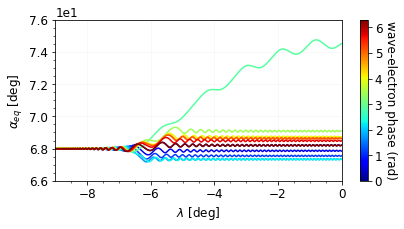

In [11]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'$\alpha_{eq}$ [deg]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(66,76)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('aeq_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

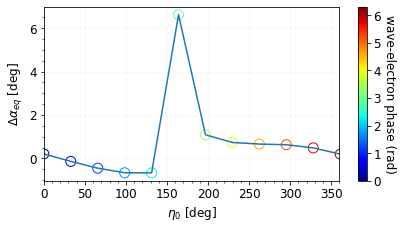

In [12]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(eta0),dalpha)
ax.scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=100)
ax.grid(alpha=.1)
ax.set_xlim(0,360)
ax.set_xlabel(r'$\eta_0$ [deg]')
ax.set_ylabel(r'$\Delta\alpha_{eq}$ [deg]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('daeq_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()


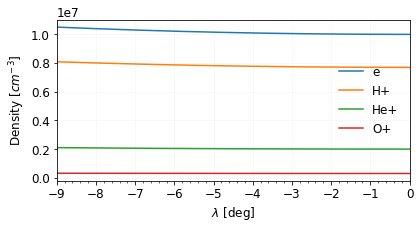

In [13]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[r,:-1]),ne_out[r,:-1],label='e')
ax.plot(np.rad2deg(lamda[r,:-1]),nH_out[r,:-1],label='H+')
ax.plot(np.rad2deg(lamda[r,:-1]),nHe_out[r,:-1],label='He+')
ax.plot(np.rad2deg(lamda[r,:-1]),nO_out[r,:-1],label='O+')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'Density [$cm^{-3}$]')

# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig('densities_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

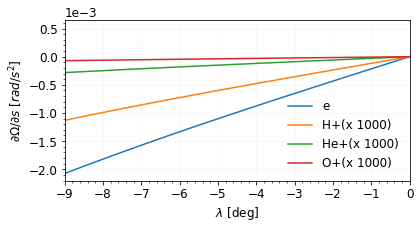

In [14]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),dwceds_out[0,:-1],label='e')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcHds_out[0,:-1]*1000,label='H+(x 1000)')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcHeds_out[0,:-1]*1000,label='He+(x 1000)')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcOds_out[0,:-1]*1000,label='O+(x 1000)')

# ax.set_yscale('symlog')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'$\partial\Omega/\partial s$ [$rad/s^2$]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('dwcds_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

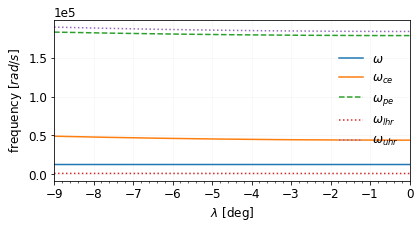

In [15]:
w_wave_array= np.full((np.shape(lamda)), w_wave)
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),w_wave_array[0,:-1],label=r'$\omega$')
ax.plot(np.rad2deg(lamda[0,:-1]),wce_out[0,:-1],label=r'$\omega_{ce}$')
ax.plot(np.rad2deg(lamda[0,:-1]),wpe_out[0,:-1],label=r'$\omega_{pe}$',linestyle='dashed')
ax.plot(np.rad2deg(lamda[0,:-1]),wlhr_out[0,:-1],label=r'$\omega_{lhr}$',linestyle='dotted')
ax.plot(np.rad2deg(lamda[0,:-1]),wuhr_out[0,:-1],label=r'$\omega_{uhr}$',linestyle='dotted')

# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'frequency [$rad/s$]')

# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('freqs_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

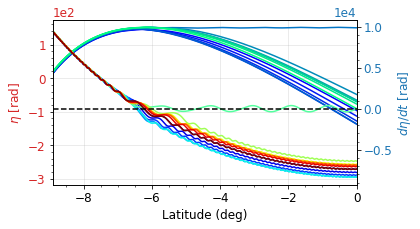

In [16]:
fig, ax1 = plt.subplots(figsize=(6,85*inch_to_mm))

color = 'tab:red'
ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('$\eta$ [rad]', color=color)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
for r in range(0,len(eta0)):
    ax1.plot(np.rad2deg(lamda[r,:-1]),eta[r,:-1],c=cmap2.to_rgba(eta0[r]))
    
ax1.tick_params(axis='y', labelcolor=color)


ax1.set_xlim(-8.9,0)
ax1.grid(alpha=.3)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
color = 'tab:blue'
ax2.set_ylabel('$d\eta/dt$ [rad]', color=color)  # we already handled the x-label with ax1
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax2.set_ylim(-0.45,0.2)
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
for r in range(0,len(eta0)):
    ax2.plot(np.rad2deg(lamda[r,:-1]),deta_dt[r,:-1],c=cmap.to_rgba(eta0[r]))
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.axhline(y=0,color="black", linestyle="--")
plt.savefig('deta_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



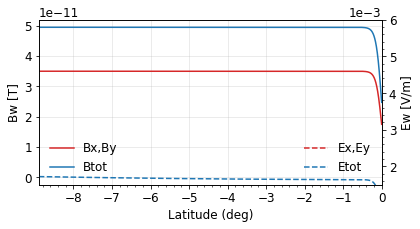

In [17]:
fig, ax1 = plt.subplots(figsize=(6,85*inch_to_mm))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('Bw [T]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax1.set_ylim(0.5*10**(-10),1.5*10**(-10))
ax1.plot(np.rad2deg(lamda[0,:-1]),Bxw_out[0,:-1],label='Bx,By',color='tab:red')
ax1.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Bxw_out[0,:-1]*Bxw_out[0,:-1]+Byw_out[0,:-1]*Byw_out[0,:-1]),label='Btot',color='tab:blue')

ax1.legend(frameon=False)
ax1.tick_params(axis='y')


ax1.set_xlim(-8.9,0)
ax1.grid(alpha=.3)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Ew [V/m]')  # we already handled the x-label with ax1
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.plot(np.rad2deg(lamda[0,:-1]),Exw_out[0,:-1],label='Ex,Ey',color='tab:red',linestyle='dashed')
ax2.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Exw_out[0,:-1]*Exw_out[0,:-1]+Eyw_out[0,:-1]*Eyw_out[0,:-1]),label='Etot',color='tab:blue',linestyle='dashed')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.tick_params(axis='y')
ax2.set_ylim(1.5*10**(-3),6*10**(-3))
ax2.legend(frameon=False,loc=4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('fields_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

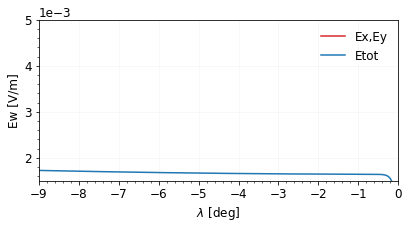

In [18]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Exw_out[0,:-1],label='Ex,Ey',color='tab:red')
ax.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Exw_out[0,:-1]*Exw_out[0,:-1]+Eyw_out[0,:-1]*Eyw_out[0,:-1]),label='Etot',color='tab:blue')

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Ew [V/m]') 
ax.set_ylim(1.5*10**(-3),5*10**(-3))
ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('electric_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

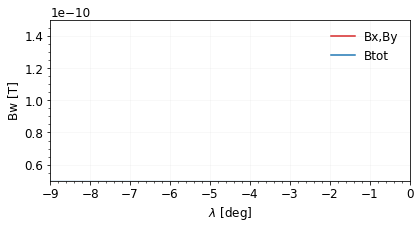

In [19]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Bxw_out[0,:-1],label='Bx,By',color='tab:red')
ax.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Bxw_out[0,:-1]*Bxw_out[0,:-1]+Byw_out[0,:-1]*Byw_out[0,:-1]),label='Btot',color='tab:blue')
# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Bw [T]') 
ax.set_ylim(0.5*10**(-10),1.5*10**(-10))
ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('magnetic_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

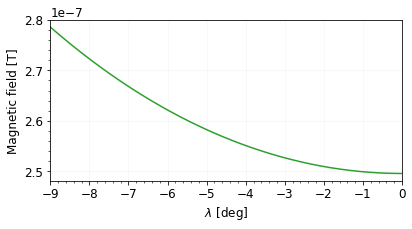

In [20]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Bmag_out[0,:-1],color='tab:green')
# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Magnetic field [T]') 
# ax.set_ylim(0.5*10**(-12),1.5*10**(-12))
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('magnetic_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

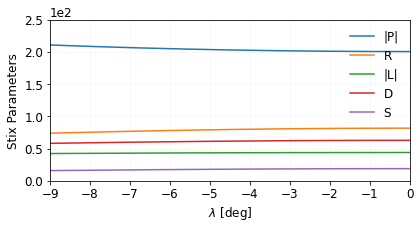

In [21]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),np.abs(P_stix[0,:-1]),label='|P|')
ax.plot(np.rad2deg(lamda[0,:-1]),R_stix[0,:-1],label='R')
ax.plot(np.rad2deg(lamda[0,:-1]),np.abs(L_stix[0,:-1]),label='|L|')
ax.plot(np.rad2deg(lamda[0,:-1]),D_stix[0,:-1],label='D')
ax.plot(np.rad2deg(lamda[0,:-1]),S_stix[0,:-1],label='S')

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Stix Parameters') 
ax.set_ylim(0,250)
ax.legend(frameon=False,loc=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('stix_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

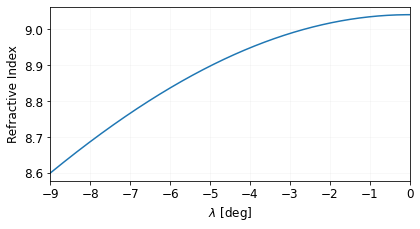

In [22]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),(mu_out[0,:-1]))

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Refractive Index') 
# ax.set_ylim(0,250)
# ax.legend(frameon=False,loc=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('mu_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


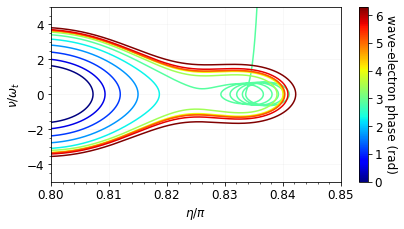

In [23]:
wtr=np.sqrt(wtrsq_out)
last=100
nplot=deta_dt/wtr

fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.1)
ax.set_xlim(0.8,0.85)
ax.set_xlabel(r'$\eta/\pi$')
ax.set_ylabel(r'$\nu/\omega_t$')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(-5,5)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('nu_nonlinear_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

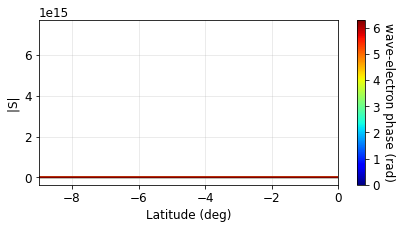

In [24]:
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,2:]),np.abs(S_out[r,2:]),c=cmap.to_rgba(eta0[r]))

ax.grid(alpha=.3)
ax.set_xlim(lamda0_deg,0)
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('|S| ')

# ax.set_ylim(0,45)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('S_nonlinear_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



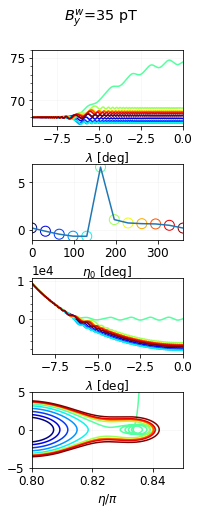

In [30]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(4,1,figsize=(3,7))


fig.suptitle('$B_y^w$=%d pT' %(By_wave/10**(-12)))


plt.tight_layout()
for r in range(0,len(eta0)):
    axs[0].plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
axs[0].grid(alpha=.1)
axs[0].set_xlim(-9,0)
axs[0].set_xlabel(r'$\lambda$ [deg]')
# axs[0].set_ylabel(r'$\alpha_{eq}$ [deg]',labelpad=10)
# axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
axs[0].set_ylim(67,76)

axs[1].plot(np.rad2deg(eta0),dalpha)
axs[1].scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=100)
axs[1].grid(alpha=.1)
axs[1].set_xlim(0,360)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

axs[1].set_xlabel(r'$\eta_0$ [deg]')
# axs[1].set_ylabel(r'$\Delta\alpha_{eq}$ [deg]',labelpad=10)

for r in range(0,len(eta0)):
    axs[2].plot(np.rad2deg(lamda[r,:-1]),deta_dt[r,:-1],c=cmap.to_rgba(eta0[r]))
    
axs[2].grid(alpha=.1)
axs[2].set_xlim(-8.9,0)
axs[2].set_xlabel(r'$\lambda$ [deg]')
# axs[2].set_ylabel(r'$d\eta/dt$ [rad]',labelpad=30)
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].yaxis.set_minor_locator(tck.AutoMinorLocator())

for r in range(0,len(eta0)):
    axs[3].plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))
axs[3].grid(alpha=.1)
axs[3].set_xlim(0.8,0.85)
axs[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[3].set_xlabel(r'$\eta/\pi$')
# axs[3].set_ylabel(r'$\nu/\omega_t$',labelpad=18)
axs[3].set_ylim(-5,5)

plt.savefig('Multi_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


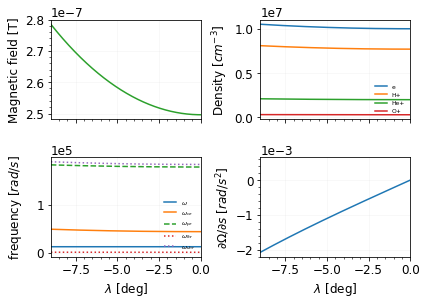

In [26]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(2,2)
# fig.suptitle('Environment_mod parameters')
plt.tight_layout()
############
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),Bmag_out[0,:-1],color='tab:green')
# ax.set_yscale('log')
ax[0,0].grid(alpha=.1)
ax[0,0].set_xlim(-9,0)
ax[0,0].tick_params(labelbottom = False)
ax[0,0].set_ylabel('Magnetic field [T]') 
# ax.set_ylim(0.5*10**(-12),1.5*10**(-12))
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0,0].xaxis.set_minor_locator(tck.AutoMinorLocator())

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),ne_out[r,:-1],label='e')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nH_out[r,:-1],label='H+')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nHe_out[r,:-1],label='He+')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nO_out[r,:-1],label='O+')
ax[0,1].grid(alpha=.1)
ax[0,1].set_xlim(-9,0)
ax[0,1].tick_params(labelbottom = False)
ax[0,1].set_ylabel(r'Density [$cm^{-3}$]')
ax[0,1].legend(frameon=False,loc=4, prop={'size': 6})
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0,1].xaxis.set_minor_locator(tck.AutoMinorLocator())

###################


ax[1,0].plot(np.rad2deg(lamda[0,:-1]),w_wave_array[0,:-1],label=r'$\omega$')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wce_out[0,:-1],label=r'$\omega_{ce}$')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wpe_out[0,:-1],label=r'$\omega_{pe}$',linestyle='dashed')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wlhr_out[0,:-1],label=r'$\omega_{lhr}$',linestyle='dotted')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wuhr_out[0,:-1],label=r'$\omega_{uhr}$',linestyle='dotted')
ax[1,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1,0].grid(alpha=.1)
ax[1,0].set_xlim(-9,0)
ax[1,0].set_xlabel(r'$\lambda$ [deg]')
ax[1,0].set_ylabel(r'frequency [$rad/s$]',labelpad=12)
ax[1,0].legend(frameon=False,loc=4, prop={'size': 6})
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].xaxis.set_minor_locator(tck.AutoMinorLocator())


##########################################
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1,1].plot(np.rad2deg(lamda[0,:-1]),dwceds_out[0,:-1],label='e')

# ax.set_yscale('symlog')
ax[1,1].grid(alpha=.1)
ax[1,1].set_xlim(-9,0)
ax[1,1].set_xlabel(r'$\lambda$ [deg]')
ax[1,1].set_ylabel(r'$\partial\Omega/\partial s$ [$rad/s^2$]')

ax[1,1].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,1].xaxis.set_minor_locator(tck.AutoMinorLocator())

for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('EnvMod_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()

In [27]:
lat=np.deg2rad(-10)
L_shell=5
Bmag=env.Bmag_dipole(L_shell,lat)
Kpmax=1
day=0
mlt=2
Rsun=90

theta=np.deg2rad(88)

ne_eq=env.density_FL_denton(ne_0,lat)
# print(ne_eq/10**7)

#assuming 84%H+, 5.4%He+, 0.6%O+
nH_eq=0.77*ne_eq
nHe_eq=0.2*ne_eq
nO_eq=0.03*ne_eq

wce_=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
wcH=env.omega_cyclotron(Bmag,env.const.qi,env.const.mH)
wcHe=env.omega_cyclotron(Bmag,env.const.qi,env.const.mHe)
wcO=env.omega_cyclotron(Bmag,env.const.qi,env.const.mO)

wpe=env.omega_plasma(ne_eq,env.const.qe,env.const.me)
wpH=env.omega_plasma(nH_eq,env.const.qi,env.const.mH)
wpHe=env.omega_plasma(nHe_eq,env.const.qe,env.const.mHe)
wpO=env.omega_plasma(nO_eq,env.const.qi,env.const.mO)

wlhr=env.omega_lhr(wce_,wpe,wcH,wpH)

f_wave=2000
w_wave=2*np.pi*f_wave

S_tmp,D_tmp,P_tmp,R_tmp,L_tmp=wave.stix_parameters(w_wave, ne_eq, nH_eq, nHe_eq, nO_eq, Bmag)


mu_sq_plus_tmp,mu_sq_minus_tmp,ref_indtmp,kappatmp,kappa_partmp,kappa_pertmp=wave.refr_index_full(theta,w_wave,S_tmp,P_tmp,R_tmp,L_tmp)

K_11,K_12,K_13,K_21,K_22,K_23,K_31,K_32,K_33=wave.cold_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO)


Ke,KH,KHe,KO=wave.warm_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO,theta)

Te=1
Ti=1
ref_ind_warm,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,theta,Te,Ti,K_11,K_22,K_33,K_12,w_wave)
S_warm,D_warm,P_warm,R_warm,L_warm=wave.stix_parameters_warm(S_tmp,D_tmp,P_tmp,Te,Ti,ref_ind_warm,Ke,KH,KHe,KO)


theta_res=wave.res_angle(P_tmp,S_tmp)-0.00001

mu_sq_plus_res,mu_sq_minus_res,ref_indres,kappares,kappa_parres,kappa_perres=wave.refr_index_full(theta_res,w_wave,S_tmp,P_tmp,R_tmp,L_tmp)


#refractive index surface
thetas=np.arange(0,360,0.1)
thetas_rad=np.deg2rad(thetas)

mupar_cold=[]
muper_cold=[]
mupar_warm_e1_i0=[]
muper_warm_e1_i0=[]
mupar_warm_e0_i1=[]
muper_warm_e0_i1=[]
mupar_warm_e1_i1=[]
muper_warm_e1_i1=[]
mupar_warm_e4_i4=[]
muper_warm_e4_i4=[]
for i in range(0,len(thetas_rad)):
    
    mu_sq_plus_tmp,mu_sq_minus_tmp,ref_cold,kappatmp,kappa_partmp,kappa_pertmp=wave.refr_index_full(thetas_rad[i],w_wave,S_tmp,P_tmp,R_tmp,L_tmp)
    Ke,KH,KHe,KO=wave.warm_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO,thetas_rad[i])
    ref_ind_warm10,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],1,0,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm01,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],0,1,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm11,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],1,1,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm44,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],4,4,K_11,K_22,K_33,K_12,w_wave)
    
    
    ref_par_cold_tmp=ref_cold*np.cos(thetas_rad[i])
    ref_per_cold_tmp=ref_cold*np.sin(thetas_rad[i])
    ref_par_warm_tmp10=ref_ind_warm10*np.cos(thetas_rad[i])
    ref_per_warm_tmp10=ref_ind_warm10*np.sin(thetas_rad[i])
    ref_par_warm_tmp01=ref_ind_warm01*np.cos(thetas_rad[i])
    ref_per_warm_tmp01=ref_ind_warm01*np.sin(thetas_rad[i])
    ref_par_warm_tmp11=ref_ind_warm11*np.cos(thetas_rad[i])
    ref_per_warm_tmp11=ref_ind_warm11*np.sin(thetas_rad[i])
    ref_par_warm_tmp44=ref_ind_warm44*np.cos(thetas_rad[i])
    ref_per_warm_tmp44=ref_ind_warm44*np.sin(thetas_rad[i])
    
    mupar_cold.append(ref_par_cold_tmp)
    muper_cold.append(ref_per_cold_tmp)
    mupar_warm_e1_i0.append(ref_par_warm_tmp10)
    muper_warm_e1_i0.append(ref_per_warm_tmp10)
    mupar_warm_e0_i1.append(ref_par_warm_tmp01)
    muper_warm_e0_i1.append(ref_per_warm_tmp01)
    mupar_warm_e1_i1.append(ref_par_warm_tmp11)
    muper_warm_e1_i1.append(ref_per_warm_tmp11)
    mupar_warm_e4_i4.append(ref_par_warm_tmp44)
    muper_warm_e4_i4.append(ref_per_warm_tmp44)

/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT/WPIT/WPIT/WaveProperties_mod/refr_index_full.py:75: RuntimeWarning: invalid value encountered in sqrt
  ref_ind=np.sqrt(refsq)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


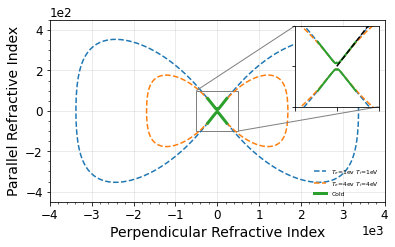

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
###########################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5
# ax.set_title('Refractive index surface, f=2kHz, L=5,')
ax.set_xlabel("Perpendicular Refractive Index",fontsize=14)
ax.set_ylabel("Parallel Refractive Index",fontsize=14)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax.plot(muper_warm_e1_i0,mupar_warm_e1_i0,label=r'$T_e$=1ev $T_i$=0eV',linestyle='--')
# ax.plot(muper_warm_e0_i1,mupar_warm_e0_i1,label=r'$T_e$=0ev $T_i$=1eV',linestyle='--')
ax.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
ax.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
ax.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=3)

ax.legend(frameon=False,loc=4, prop={'size': 6})
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.set_xlim(-4000,4000)
ax.set_ylim(-450,450)
ax.grid(alpha=.3)
scale=10
axins = zoomed_inset_axes(ax, 2, loc=1)
axins.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
axins.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
axins.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=2)
axins.plot([0, scale*ref_indres*np.sin(theta_res)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')
# axins.plot([0, scale*ref_indres*np.sin(theta_res-np.pi)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')

axins.set_xlim(-500, 500)
axins.set_ylim(-100, 100)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.savefig('Refr_surf_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()

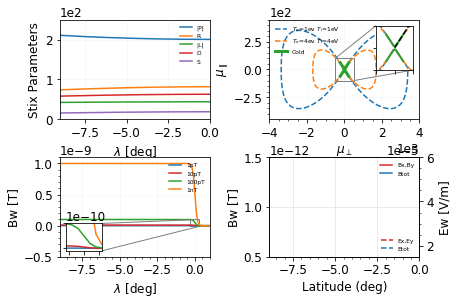

In [29]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(2,2)
# fig.suptitle('WaveProperties_mod parameters')
plt.tight_layout()
############
ax[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),np.abs(P_stix[0,:-1]),label='|P|')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),R_stix[0,:-1],label='R')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),np.abs(L_stix[0,:-1]),label='|L|')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),D_stix[0,:-1],label='D')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),S_stix[0,:-1],label='S')

ax[0,0].grid(alpha=.1)
ax[0,0].set_xlim(-9,0)
ax[0,0].set_xlabel(r'$\lambda$ [deg]')
ax[0,0].set_ylabel('Stix Parameters') 
ax[0,0].set_ylim(0,250)
ax[0,0].legend(frameon=False,loc=1, prop={'size': 6})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].set_xlabel(r'$\mu_\perp$')
ax[0,1].set_ylabel(r'$\mu_\parallel$')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax.plot(muper_warm_e1_i0,mupar_warm_e1_i0,label=r'$T_e$=1ev $T_i$=0eV',linestyle='--')
# ax.plot(muper_warm_e0_i1,mupar_warm_e0_i1,label=r'$T_e$=0ev $T_i$=1eV',linestyle='--')
ax[0,1].plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
ax[0,1].plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
ax[0,1].plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=3)
ax[0,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[0,1].legend(frameon=False,loc=2, prop={'size': 6})
ax[0,1].yaxis.get_ticklocs(minor=True)
ax[0,1].minorticks_on()
ax[0,1].set_xlim(-4000,4000)
ax[0,1].set_ylim(-450,450)
ax[0,1].grid(alpha=.1)
scale=10
axins = zoomed_inset_axes(ax[0,1], 2, loc=1)
axins.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
axins.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
axins.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=2)
axins.plot([0, scale*ref_indres*np.sin(theta_res)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')
# axins.plot([0, scale*ref_indres*np.sin(theta_res-np.pi)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')

axins.set_xlim(-500, 500)
axins.set_ylim(-100, 100)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax[0,1], axins, loc1=2, loc2=4, fc="none", ec="0.5")
###################


ax[1,0].plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
ax[1,0].plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
ax[1,0].plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
ax[1,0].plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')
ax[1,0].grid(alpha=.1)
ax[1,0].set_xlim(-9,1)
ax[1,0].set_xlabel(r'$\lambda$ [deg]')
ax[1,0].set_ylabel(r'Bw [T]')

# ax[1,0].set_yscale('log')
ax[1,0].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].set_ylim(-0.5*10**(-9),1.1*10**(-9))
ax[1,0].legend(frameon=False,loc=0, prop={'size': 6})

axins2 = zoomed_inset_axes(ax[1,0], 4, loc=3)
axins2.plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
axins2.plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
axins2.plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
axins2.plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')

axins2.set_xlim(-0.3, 0.3)
axins2.set_ylim(-0.01*10**(-9), 0.1*10**(-9))
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax[1,0], axins2, loc1=1, loc2=4, fc="none", ec="0.5")
##########################################
ax[1,1].set_xlabel('Latitude (deg)')
ax[1,1].set_ylabel('Bw [T]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1,1].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,1].set_ylim(0.5*10**(-12),1.5*10**(-12))
ax[1,1].plot(np.rad2deg(lamda[0,:-1]),Bxw_out[0,:-1],label='Bx,By',color='tab:red')
ax[1,1].plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Bxw_out[0,:-1]*Bxw_out[0,:-1]+Byw_out[0,:-1]*Byw_out[0,:-1]),label='Btot',color='tab:blue')

ax[1,1].legend(frameon=False, prop={'size': 6})
ax[1,1].tick_params(axis='y')


ax[1,1].set_xlim(-8.9,0)
ax[1,1].grid(alpha=.3)
ax2 = ax[1,1].twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Ew [V/m]')  # we already handled the x-label with ax1
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.plot(np.rad2deg(lamda[0,:-1]),Exw_out[0,:-1],label='Ex,Ey',color='tab:red',linestyle='dashed')
ax2.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Exw_out[0,:-1]*Exw_out[0,:-1]+Eyw_out[0,:-1]*Eyw_out[0,:-1]),label='Etot',color='tab:blue',linestyle='dashed')

ax2.tick_params(axis='y')
ax2.set_ylim(1.5*10**(-5),6*10**(-5))
ax2.legend(frameon=False,loc=4, prop={'size': 6})

for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('WaveMod_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()